In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Problem description
In this notebook we will develop several recurrent neural network (RNNs) models trying to solve a prediction problem for time series.

## Dataset description
We will use the ["Walmart Sales Dataset of 45 Stores"](https://www.kaggle.com/datasets/yasserh/walmart-dataset) (Kaggle dataset). The file has
information about the Weekly Sales of 45 stores for the year 2010-2012, including the factors
affecting Sales such as Holidays, Temperature, Fuel Price, CPI (Consumer Price Index), and
Unemployment. 

### Configure the environment
Set the following variables with your specific configuration:

In [1]:
# Set Random Seed to ensure reproducibility of the experiments
RANDOM_SEED = 54

# Directory parameters
DATASET_PATH = './datasets'
OUT_MODELS_FOLDER = "./output"

### Prepare the environment

In [2]:
import os, random

from tensorflow import keras
from tensorflow.keras import utils, layers, optimizers, applications, regularizers, callbacks

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tabulate import tabulate

from itertools import product

# AUXILIARY FUNCTIONS
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r-o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()


def plot_results(history, stdSales):

  history = history.history
  loss, val_loss = history['loss'], history['val_loss']
  mae, val_mae = history['mae'], history['val_mae']

  # denormalize mae
  mae      = [x*stdSales for x in mae]
  val_mae = [x*stdSales for x in val_mae]

  epochs = range(1, len(loss) + 1)
  fig, axs = plt.subplots(1, 2, figsize=(9,4))

  for idx, measure in enumerate(["loss", "mae"]):
    axs[idx].plot(epochs, eval(measure), 'b-o', label=f'Training {measure}')
    axs[idx].plot(epochs, eval(f"val_{measure}"), 'r-o', label=f'Validation {measure}')
    axs[idx].set_title(f'Training and validation {measure}')
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel(measure.capitalize())
    axs[idx].legend()

  plt.tight_layout()
  plt.show()

# GenerateWalmartDataset Functions
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSaples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset

def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

def plot_timeseries_dataset(train_dataset,test_dataset):
    """
    Plots a time series dataset generated using keras.utils.timeseries_dataset_from_array divided in trainining and test.

    Parameters:
    - train_dataset: Training time series dataset
    - test_dataset: Test time series dataset

    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize=(10,6))

    train_targets = []
    test_targets = []

    for batch in train_dataset:
        _, target = batch
        train_targets.append(target)

    for batch in test_dataset:
        _, target = batch
        test_targets.append(target)

    ax.plot(range(len(train_targets)), train_targets, color="blue", alpha=0.5, label='Train data')
    ax.plot(range(len(train_targets),len(train_targets)+len(test_targets)), test_targets, color="red", alpha=0.5, label='Test data')

    ax.set_xlabel("Time")
    ax.set_ylabel("Weekly sales")
    ax.set_title("Weekly sales Time Series")
    plt.legend()
    plt.show()
    
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

2024-03-26 14:25:09.771544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 14:25:10.416811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 14:25:10.417064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 14:25:10.515979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 14:25:10.727096: I tensorflow/core/platform/cpu_feature_guar

## 1. Preprocess the dataset

This step will load and prepare the dataset for training and evaluation.

Some comments about the dataset:
- It has 6,435 data rows (143 for each store). The rows are ordered by store and, for each store, by date.
- The file `generateWalmartDataset` functions create the time series for training and testing. Test data is the 20% most recent data of all stores.
- The train subset will be further subdivided, leaving 10% of the data for validation.
- Variables in the time series have been normalized by the
`generateTrainTestData` method to facilitate the learning process of the networks. Thus, for a variable x, the variable has been transformed to x’=(x-µx)/σx, where µx is the mean of the variable and σx is the standard deviation.
- The **output feature** (the feature to be predicted) is the weakly sales in 3 weeks.
- In each batch iteration, 1 (BATCHSIZE) sequences are seen.
- The **Sequence length** refers to the number of consecutive data points or observations used as inputs to predict the subsequent data point. A longer sequence length can capture more complex patterns in the data but may also increase the computational complexity of the model. On the other hand, a shorter sequence length may lead to a simpler model but may overlook important long-term dependencies in the data. Initially we will use a sequence length of 2. In this case, it refers to the number of weeks (observations) of data to be used as input.


The dataset in `.csv` format located in `datasets`. This dataset contains: 
- Store
- Date
- Weekly_Sales (target -> recall that it is going to be predicted for the 3rd week after the last element of the sequence)
- Holiday_Flag
- Temperature_Temperature
- Fuel_Price
- CPI
- Unemployment

Regarding `generateWalmartDataset` functions a quick description is given for a better comprehension of its functionalities: 

- The readData function is employed to load the .csv file, followed by the removal of date entries from the feature set.

- Subsequently, the dataset undergoes partitioning into training and testing sets via the splitTrainTest function, preserving proportions per store while also normalizing the data. An additional dimension representing the store "id" is appended to the resulting matrix.

- Lastly, for each store within the training and testing sets, data sequences are constructed. These sequences serve as the input samples for recurrent networks. The generation of these time-series sequences is facilitated by the generateTimeSeries function, which essentially leverages a specific function within the tensorflow library.


NOTE: It is important to consider that, since we will not be using a validation set, we employ the test set as validation set to measure the performance of the models along training and detecting possible overfitting. This operation may introduce bias into the model evaluation process because the model's hyperparameters may inadvertently be tuned to perform well specifically on the test set, leading to an overestimation of the model's generalization performance.

stdSales=571854.7800576452
nFeatures=6
samples.shape=TensorShape([1, 2, 6])
targets.shape=TensorShape([1])


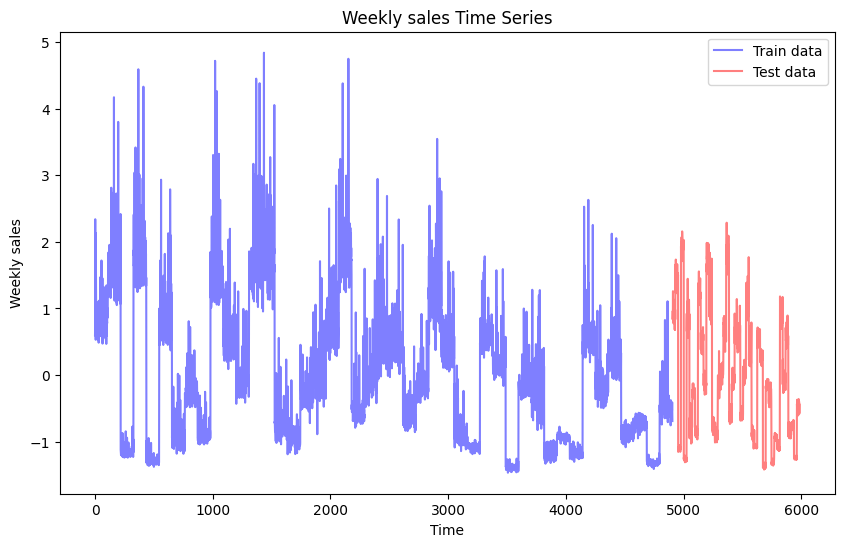

In [18]:
# Set the path for the dataset
assert os.path.exists(DATASET_PATH), f'Verify the dataset is located at {DATASET_PATH}'

# CONSTANT VALUES (cannot be modified)
TESTPERCENT = 0.2
BATCHSIZE = 1

# Sequence length can be modified
seqLength = 2

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

print(f"{stdSales=}")
print(f"{nFeatures=}")

for samples, targets in trainData:
    print(f"{samples.shape=}")
    print(f"{targets.shape=}")
    break

plot_timeseries_dataset(trainData, testData)

## 2. Develop a custom recurrent network for the regression problem.

This section describes the training process and presents various experiments involving multiple networks and recurrent architectures. It is essential to emphasize the use of recurrent networks because of their inherent ability to handle sequential data. Specifically, the investigation covers three types of recurrent networks:

- **Recurrent Neural Network** (RNN): Serving as the basic form of recurrent networks, it establishes connections between previous predictions and the current prediction. This connection makes it effective in modeling temporal data by using past information to predict future outputs.

- **Long-Short Term Memory** (LSTM): Addressing the limitations of RNNs, where information from earlier time steps fades over time due to gradient calculations, LSTM is designed to maintain long-term memory within the network. Its architecture includes gates that selectively retain or discard information from previous states.

- **Gated Recurrent Unit** (GRU): Providing a simplified version of LSTM, GRU operates with fewer operations while still incorporating gating mechanisms to control information flow. Consequently, GRUs operate more efficiently and require less memory compared to LSTMs.

Additionally, attention is drawn to the flexibility in parameterization enabled by the `create_model` function.

---

The basic architecture for our initial experiments is composed of an **Input** layer, followed by the **recurrent/s** layer/s, followed by an optional **dense** layer.

In order to determine the best architecture of the model several experiments are carried out below to find the architecture which best fits to out regression problem. Once the best architecture is obtained, we will check if there is a problem of **overfitting** and, if so, will apply regularization techniques to check if the performance of the network is affected.

**MAE** will be the metric in use to evaluate the performance of the trained regressors. As it reflects the average magnitude of the errors in a set of predictions, it is particularly suitable for this problem. Another important fact is that since data is normalized, we denormalize MAE to provide the final result multiplying the normalized MAE by the standard deviation of the weekly sales.

Note that the most relevant trained models will be saved into `./output` folder making possible a later analysis.

In [9]:
def create_model(recurrent_unit=layers.LSTM, cell_units=[64,64], dropout=(0.,0.,0.), hidden_layer=None, regularization=(0,0), **kwargs):
  # Input
  inputs = keras.Input(shape=(seqLength, nFeatures))

  # Recurrent layers
  lstm_dropout, recurrent_dropout, dense_dropout = dropout
  for i, units in enumerate(cell_units):
    if i==0:
      x = recurrent_unit(units, return_sequences=len(cell_units[i:]) != 1, recurrent_dropout=recurrent_dropout, dropout=lstm_dropout, kernel_regularizer=regularizers.L1L2(l1=regularization[0], l2=regularization[1]))(inputs)
    else:
      x = recurrent_unit(units, return_sequences=len(cell_units[i:]) != 1, recurrent_dropout=recurrent_dropout, dropout=lstm_dropout, kernel_regularizer=regularizers.L1L2(l1=regularization[0], l2=regularization[1]))(x)

  # Dense dropout 
  if dense_dropout != 0.:
    x = layers.Dropout(dense_dropout)(x)

  # Dense layer    
  if hidden_layer is not None:
    x = layers.Dense(hidden_layer)(x)

  # Output layer 
  outputs = layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model
  

def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=optimizers.RMSprop, checkpoint=None, lr_scheduler=None, early_stop=None, **kwargs):

  model.compile(optimizer=optimizer(learning_rate=lr), loss="mse", metrics=["mae"])

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def execute_pipeline(train_dataset, val_dataset, hyperparameters, stdSales):

  # Set the seed to ensure reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  model = create_model(**hyperparameters)
  history = train_model(model, train_dataset, val_dataset, **hyperparameters)
  plot_results(history, stdSales)

  # Get best mae and denormalize it
  best_train_mae = min(history.history['mae'])*stdSales
  best_val_mae = min(history.history['val_mae'])*stdSales

  print("Best training MAE:", best_train_mae)
  print("Best test MAE:", best_val_mae)

  return model, history

## 3. Optimal model search

Initially, understanding the complexity of the problem involves trial and error, which entails creating, training, and examining various networks ranging from simple to complex ones. First we carry out an approximation using a **sequence size of 2** (2 weeks of data). The primary strategy to prevent overfitting will be **Early Stopping**, a method particularly useful for avoiding unnecessary computation and halting training when the model ceases to learn.

Our approach involves testing networks with a single recurrent cell initially, followed by employing two recurrent cells to create a deeper architecture. Subsequently, we will explore various parameter values such as learning rate, dense hidden layers, sequence length, and different optimizers.

Further discussion of the results can be found in the last sections.

#### Training and evaluating a densely connected model

* It is useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.
* The following listing shows a fully connected model that starts by flattening the data and then runs it through two `Dense` layers. 
* Note the lack of an activation function on the last `Dense` layer, which is typical for a regression problem. 
* We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it is smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in `compile()`.

In [8]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ # Save the best performing model
    keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + "/walmart_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

# Reload the best modle and evaluate it on the test data
model = keras.models.load_model("walmart_dense.keras")
print(f"Test MAE: {model.evaluate(testData)[1]*stdSales:.2f}")

Epoch 1/10


4905/4905 [==============================] - 29s 6ms/step - loss: 0.2136 - mae: 0.2750 - val_loss: 0.0906 - val_mae: 0.2232
Epoch 2/10
4905/4905 [==============================] - 29s 6ms/step - loss: 0.1077 - mae: 0.1950 - val_loss: 0.0966 - val_mae: 0.2349
Epoch 3/10
4905/4905 [==============================] - 28s 6ms/step - loss: 0.0928 - mae: 0.1832 - val_loss: 0.1323 - val_mae: 0.2687
Epoch 4/10
4905/4905 [==============================] - 26s 5ms/step - loss: 0.0814 - mae: 0.1748 - val_loss: 0.1440 - val_mae: 0.2870
Epoch 5/10
4905/4905 [==============================] - 26s 5ms/step - loss: 0.0743 - mae: 0.1688 - val_loss: 0.1269 - val_mae: 0.2685
Epoch 6/10
4905/4905 [==============================] - 24s 5ms/step - loss: 0.0693 - mae: 0.1645 - val_loss: 0.1211 - val_mae: 0.2606
Epoch 7/10
4905/4905 [==============================] - 25s 5ms/step - loss: 0.0667 - mae: 0.1613 - val_loss: 0.1398 - val_mae: 0.2809
Epoch 8/10
4905/4905 [==============================] - 25s 5ms/st

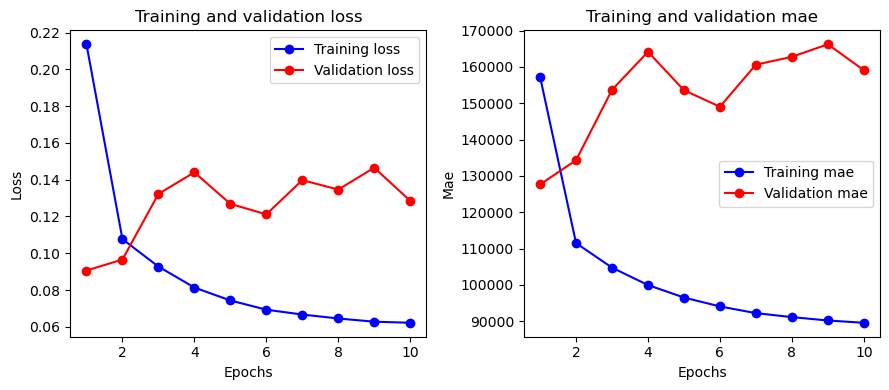

In [9]:
plot_results(history, stdSales)

The densely connected network demonstrates a progressive decrease in both loss and mean absolute error (MAE) throughout the training epochs. However, upon evaluation on the test set, the network exhibits a substantially higher MAE of approximately 127,661.11 with respect to the expected MAE of 68,000, indicating a significant performance deterioration when applied to unseen data. This considerable deviation underscores the limitations of densely connected networks in effectively capturing the intricate temporal dependencies inherent in time series data. Unlike recurrent neural networks (RNNs), which excel in preserving sequential information over time, densely connected networks lack this inherent capability, making them less suitable for time series forecasting tasks. Therefore, let's now test what happens when using an RNN.

## APPROXIMATION 1: Using a sequence length of 2

From the various runs conducted, we started with simpler models and gradually moved towards more complex ones. We evaluated simple architectures with a sequence size of 2. Models employing simple RNN recurrent units demonstrated notably lower performance compared to others. While GRUs showed slightly better performance for the biggest architecture tested (128 neurons in the recurrent cell), LSTMs consistently outperformed other models across subsequent runs. Specifically, the best outcome achieved with these initial models was the 2 stacked LSTM (32,32) with a test MAE of 88047. In general the MAE values were really high, surpassing the 100,000 and even the densely connected model results due to the early overfitting problem as the model start to overtrain in the first epoch. Also note that the simplest (32,32) models with two stacked recurrent cells provided the best results in all the experiments.

Furthermore, numerous runs were conducted with variations in model hyperparameters, including modifications to learning rates, utilization of learning rate schedulers, experimentation with different optimization algorithms, and integration of more complex hidden dense layer classifiers. Despite these adjustments, no improvement was observed except for the use of Adam optimizer which reduced test MAE until around 80000.

### Hyperparameters example

In [ ]:
hyperparameters = {
    "epochs": 50, # maximum number of epochs to train the network
    "lr": 0.001, # initial learning rate of the optimizer
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32], # number of cells of the recurrent unit
    "dropout": (0.,0.,0.), # (lstm_dropout, recurrent_dropout, dense_dropout). If 0. no dropout added
    "hidden_layer": 32, # units of the hidden layer, if None no hidden layer
    "weight_regularization": (0.,0.), # (L1 regularization lambda, L2 regularization lambda) If 0. no weight regularization added
    "lr_scheduler": callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

### Single RNN (16 units)
- Best test MAE: 138378 (GRU)
- Overfitting after the first epoch

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1489 (5.82 KB)
Trainable params: 1489 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1303 - mae: 0.2101 - val_loss: 0.1613 - val_mae: 0.2893
Epoch 2/50
4905/4905 [==============================] - 19s 4ms/step - loss: 0.0906 - mae: 0.1781 - val_loss: 0.2036 - val_mae: 0.3114
Epoch 3/50
4905/4905 

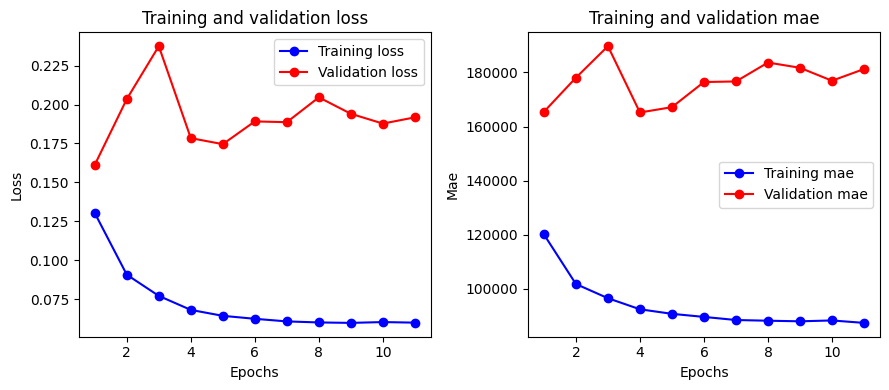

Best training MAE: 87462.17421007644
Best test MAE: 165199.6019703303


(<keras.src.engine.functional.Functional at 0x153a2497ce10>,
 <keras.src.callbacks.History at 0x153a11451350>)

In [10]:
# LSTM 16
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [16],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                368       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 22s 4ms/step - loss: 0.1362 - mae: 0.2133 - val_loss: 0.1732 - val_mae: 0.3182
Epoch 2/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1010 - mae: 0.1891 - val_loss: 0.1513 - val_mae: 0.3019
Epoch 3/50
4905/4905 [=

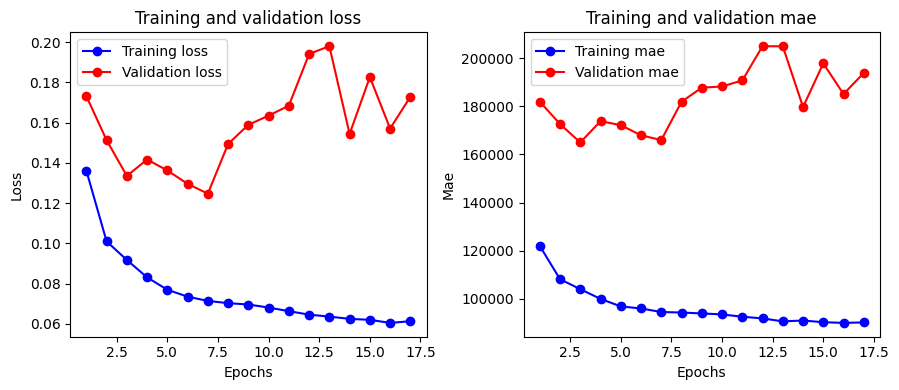

Best training MAE: 89991.824447003
Best test MAE: 165019.93887570937


(<keras.src.engine.functional.Functional at 0x153a2475d5d0>,
 <keras.src.callbacks.History at 0x153a2493c4d0>)

In [11]:
# RNN 16
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_2 (GRU)                 (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.1209 - mae: 0.2022 - val_loss: 0.1132 - val_mae: 0.2420
Epoch 2/50
4905/4905 [==============================] - 19s 4ms/step - loss: 0.0824 - mae: 0.1723 - val_loss: 0.1335 - val_mae: 0.2691
Epoch 3/50
4905/4905 

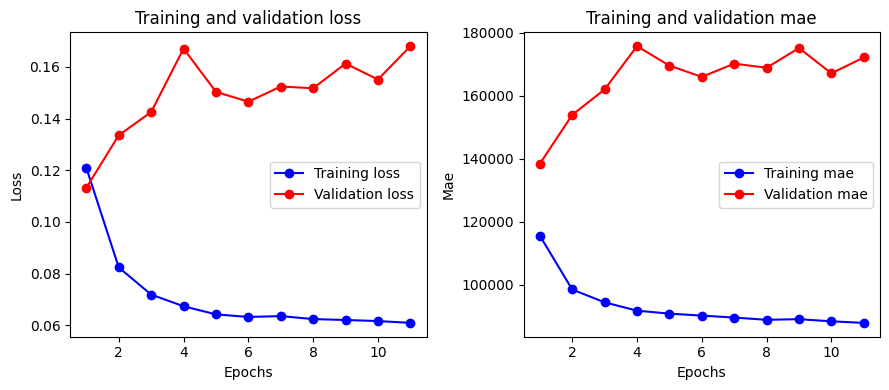

Best training MAE: 87896.64974628577
Best test MAE: 138378.7838471718


(<keras.src.engine.functional.Functional at 0x153a246170d0>,
 <keras.src.callbacks.History at 0x153a2447ec90>)

In [12]:
# GRU 16
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (32 units)
- Best test MAE: 144361 (LSTM)
- Overfitting after the first epoch

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5025 (19.63 KB)
Trainable params: 5025 (19.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-03-09 12:38:59.562137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-09 12:39:00.406049: I external/local_xla/xla/service/service.cc:168] XLA service 0x1515d430fdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 12:39:00.406073: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-09 12:39:00.410939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709984340.494026  450773 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4905/4905 [==============================] - 23s 4ms/step - loss: 0.1206 - mae: 0.1999 - val_loss: 0.1370 - val_mae: 0.2524
Epoch 2/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0842 - mae: 0.1733 - val_loss: 0.2070 - val_mae: 0.2869
Epoch 3/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0737 - mae: 0.1654 - val_loss: 0.2086 - val_mae: 0.2907
Epoch 4/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0677 - mae: 0.1602 - val_loss: 0.1803 - val_mae: 0.2764
Epoch 5/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0639 - mae: 0.1579 - val_loss: 0.1774 - val_mae: 0.2839
Epoch 6/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0613 - mae: 0.1545 - val_loss: 0.1679 - val_mae: 0.2784
Epoch 7/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0597 - mae: 0.1532 - val_loss: 0.1775 - val_mae: 0.2869
Epoch 8/50
4905/4905 [==============================] - 20s 4ms/st

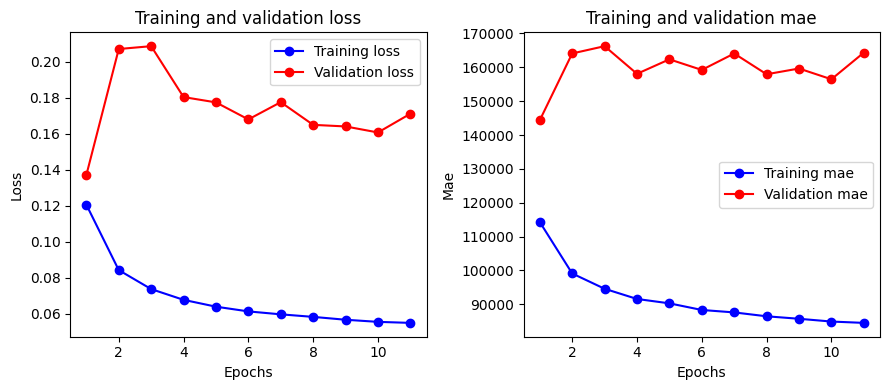

Best training MAE: 84528.4950427592
Best test MAE: 144361.12008617548


(<keras.src.engine.functional.Functional at 0x151a2dc8de50>,
 <keras.src.callbacks.History at 0x1519bc613bd0>)

In [5]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1248      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 23s 4ms/step - loss: 0.1139 - mae: 0.2086 - val_loss: 0.2902 - val_mae: 0.4122
Epoch 2/50
4905/4905 [==============================] - 22s 4ms/step - loss: 0.0898 - mae: 0.1887 - val_loss: 0.2484 - val_mae: 0.3847
Epoch 3/50
4905/4905 

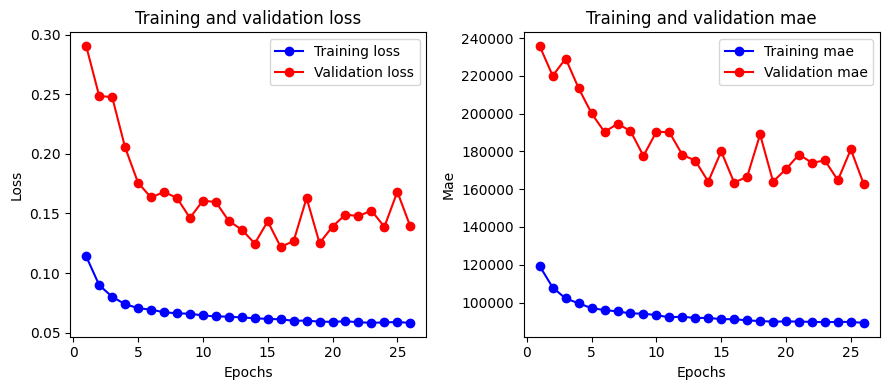

Best training MAE: 89218.84025807993
Best test MAE: 162603.70714520494


(<keras.src.engine.functional.Functional at 0x1519b091c590>,
 <keras.src.callbacks.History at 0x151947213fd0>)

In [6]:
# RNN 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru (GRU)                   (None, 32)                3840      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3873 (15.13 KB)
Trainable params: 3873 (15.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1058 - mae: 0.1934 - val_loss: 0.1487 - val_mae: 0.2937
Epoch 2/50
4905/4905 [==============================] - 19s 4ms/step - loss: 0.0769 - mae: 0.1701 - val_loss: 0.1483 - val_mae: 0.2843
Epoch 3/50
4905/490

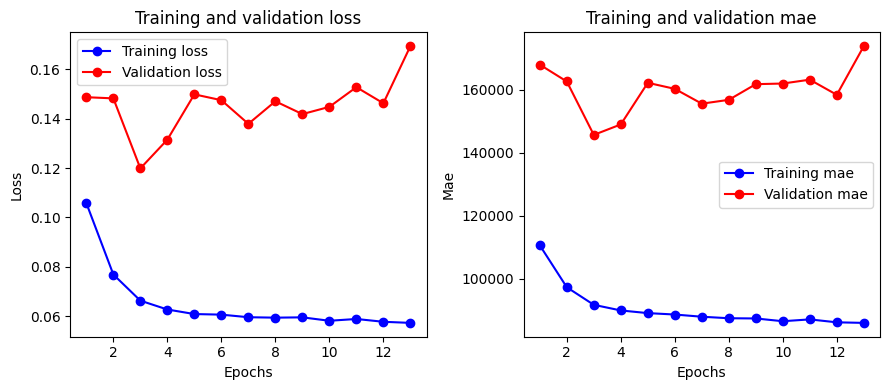

Best training MAE: 85983.98425447535
Best test MAE: 145636.55422345886


(<keras.src.engine.functional.Functional at 0x151946054fd0>,
 <keras.src.callbacks.History at 0x15194607bf10>)

In [7]:
# GRU 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (64 units)
- Best test MAE: 138313 (LSTM)
- Overfitting after the first epoch

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1155 - mae: 0.1988 - val_loss: 0.1200 - val_mae: 0.2419
Epoch 2/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0816 - mae: 0.1732 - val_loss: 0.1459 - val_mae: 0.2596
Epoch 3/50
4905/4

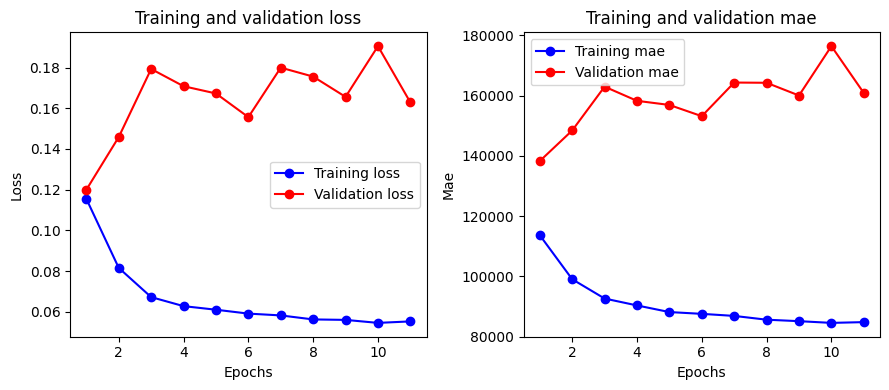

Best training MAE: 84579.99778151317
Best test MAE: 138313.48512330157


(<keras.src.engine.functional.Functional at 0x1519bc075310>,
 <keras.src.callbacks.History at 0x151945e7d790>)

In [8]:
# LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4544      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 23s 4ms/step - loss: 0.1191 - mae: 0.2167 - val_loss: 0.2971 - val_mae: 0.4367
Epoch 2/50
4905/4905 [==============================] - 22s 4ms/step - loss: 0.0933 - mae: 0.1915 - val_loss: 0.2710 - val_mae: 0.4268
Epoch 3/50
4905/490

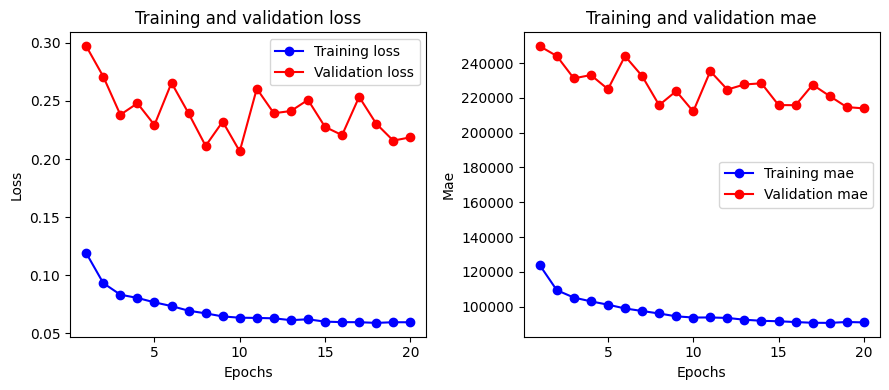

Best training MAE: 90681.7344797195
Best test MAE: 212206.72426246558


(<keras.src.engine.functional.Functional at 0x151945c0c3d0>,
 <keras.src.callbacks.History at 0x1519455f4510>)

In [9]:
# RNN 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13889 (54.25 KB)
Trainable params: 13889 (54.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1098 - mae: 0.1963 - val_loss: 0.1321 - val_mae: 0.2810
Epoch 2/50
4905/4905 [==============================] - 19s 4ms/step - loss: 0.0761 - mae: 0.1715 - val_loss: 0.1229 - val_mae: 0.2634
Epoch 3/50
4905/4

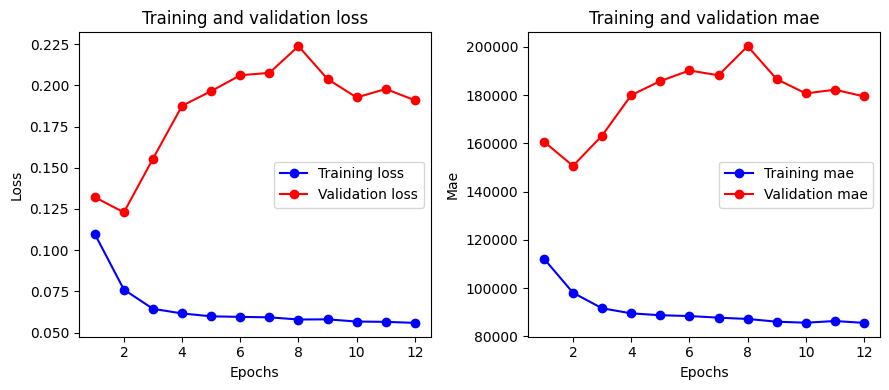

Best training MAE: 85582.2134686528
Best test MAE: 150653.2141108254


(<keras.src.engine.functional.Functional at 0x151944417c10>,
 <keras.src.callbacks.History at 0x151944422e90>)

In [10]:
# GRU 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (128 units)
- Best test MAE: 126701 (GRU)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               69120     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69249 (270.50 KB)
Trainable params: 69249 (270.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 22s 4ms/step - loss: 0.1114 - mae: 0.1998 - val_loss: 0.1407 - val_mae: 0.2694
Epoch 2/50
4905/4905 [==============================] - 20s 4ms/step - loss: 0.0825 - mae: 0.1767 - val_loss: 0.2088 - val_mae: 0.3014
Epoch 3/50
4905

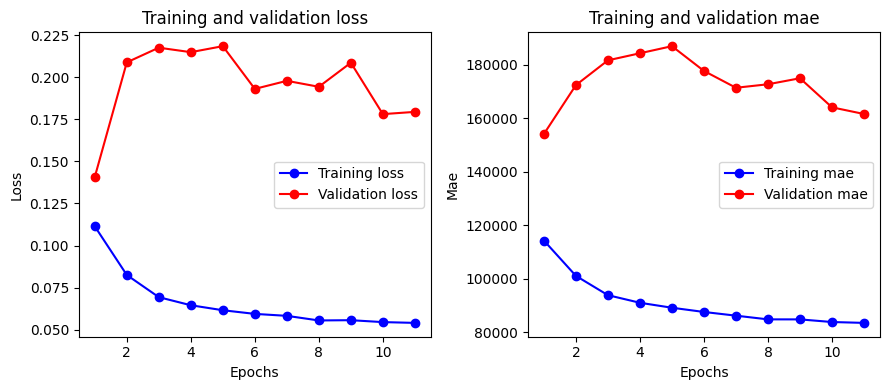

Best training MAE: 83461.41521806244
Best test MAE: 154084.62242616052


(<keras.src.engine.functional.Functional at 0x1519445d5910>,
 <keras.src.callbacks.History at 0x1515d9a23f10>)

In [11]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               17280     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 17409 (68.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 23s 4ms/step - loss: 0.1354 - mae: 0.2284 - val_loss: 0.3529 - val_mae: 0.4682
Epoch 2/50
4905/4905 [==============================] - 22s 4ms/step - loss: 0.0955 - mae: 0.1905 - val_loss: 0.2572 - val_mae: 0.4121
Epoch 3/50
4905/4

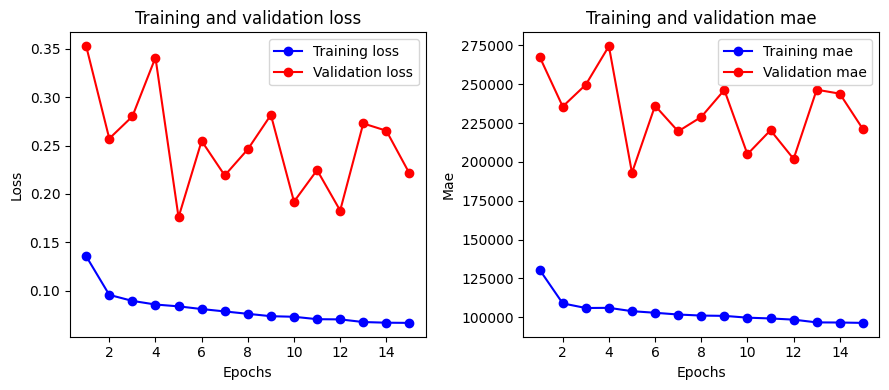

Best training MAE: 96394.55051289102
Best test MAE: 193021.10194658214


(<keras.src.engine.functional.Functional at 0x151944f50750>,
 <keras.src.callbacks.History at 0x151946023f10>)

In [12]:
# RNN 128
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_2 (GRU)                 (None, 128)               52224     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 21s 4ms/step - loss: 0.1099 - mae: 0.1985 - val_loss: 0.1931 - val_mae: 0.3337
Epoch 2/50
4905/4905 [==============================] - 19s 4ms/step - loss: 0.0778 - mae: 0.1743 - val_loss: 0.1706 - val_mae: 0.2975
Epoch 3/50
4905

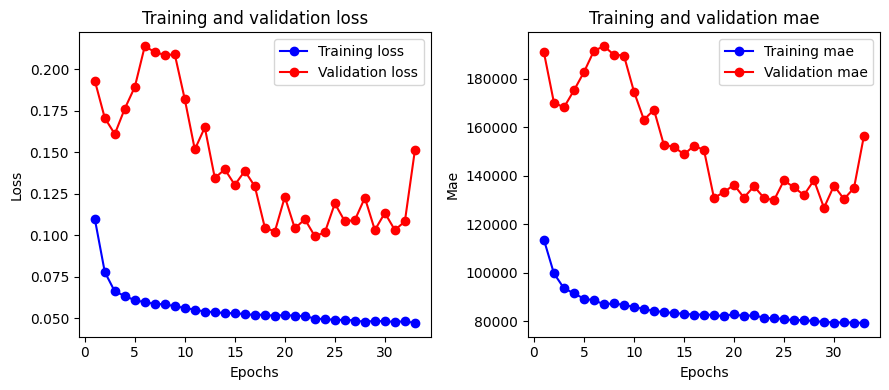

Best training MAE: 79223.42322689046
Best test MAE: 126701.42404993346


(<keras.src.engine.functional.Functional at 0x1515d8e71110>,
 <keras.src.callbacks.History at 0x1515d8d03f10>)

In [13]:
# GRU 128
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 stacked recurrent layers (32,32 units)
- Best test MAE: 88047 (LSTM)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 2, 32)             4992      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13345 (52.13 KB)
Trainable params: 13345 (52.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 27s 5ms/step - loss: 0.1235 - mae: 0.2033 - val_loss: 0.2326 - val_mae: 0.3628
Epoch 2/50
4905/4905

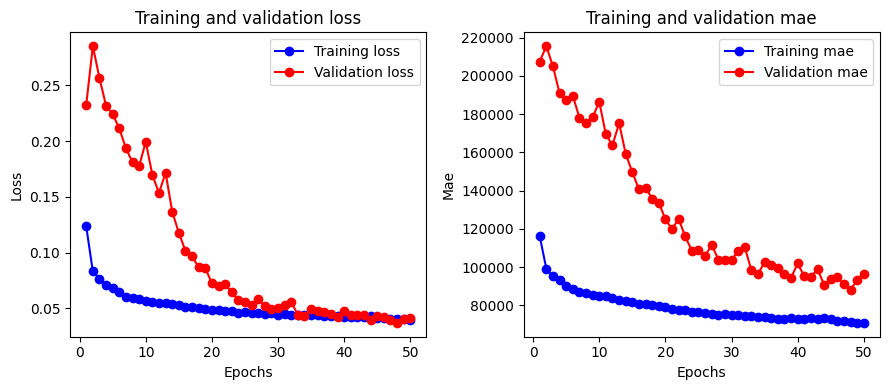

Best training MAE: 70902.97853813956
Best test MAE: 88047.29781353124


(<keras.src.engine.functional.Functional at 0x1515b0d8cd50>,
 <keras.src.callbacks.History at 0x1515b0c8bfd0>)

In [14]:
# LSTM 32 and 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 2, 32)             1248      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3361 (13.13 KB)
Trainable params: 3361 (13.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 36s 7ms/step - loss: 0.1220 - mae: 0.2153 - val_loss: 0.3783 - val_mae: 0.5057
Epoch 2/50
4905/4905 

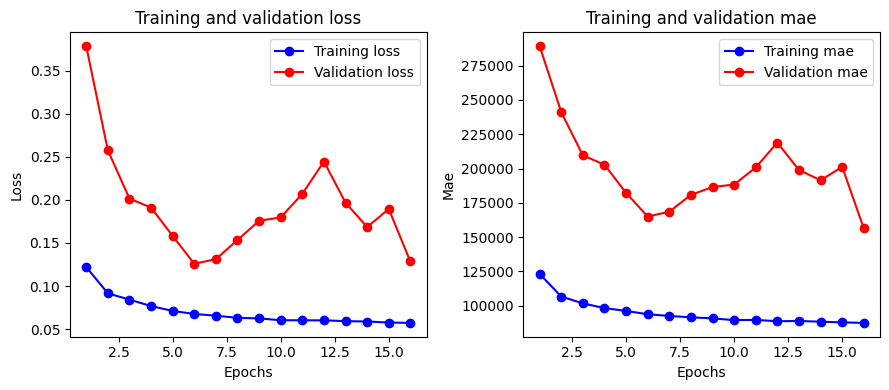

Best training MAE: 87474.04438133459
Best test MAE: 156408.14240986758


(<keras.src.engine.functional.Functional at 0x1515d8a644d0>,
 <keras.src.callbacks.History at 0x15157285bf10>)

In [15]:
# RNN 32 and 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 gru_3 (GRU)                 (None, 2, 32)             3840      
                                                                 
 gru_4 (GRU)                 (None, 32)                6336      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10209 (39.88 KB)
Trainable params: 10209 (39.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 25s 5ms/step - loss: 0.1043 - mae: 0.1929 - val_loss: 0.2175 - val_mae: 0.3590
Epoch 2/50
4905/490

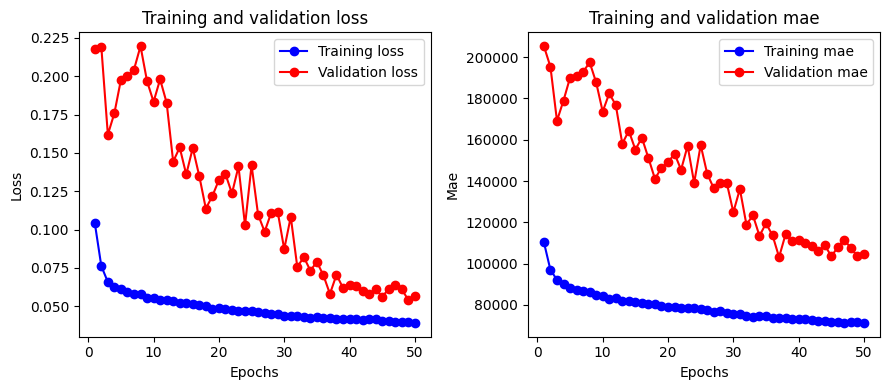

Best training MAE: 71284.91599761367
Best test MAE: 103152.17169188718


(<keras.src.engine.functional.Functional at 0x1515b0f6ce10>,
 <keras.src.callbacks.History at 0x1515b0e03fd0>)

In [16]:
# GRU 32 and 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 stacked recurrent layers (64,64 units)
- Best test MAE: 169403 (LSTM)
- Overfitting after the first epoch

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 2, 64)             18176     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 51265 (200.25 KB)
Trainable params: 51265 (200.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 26s 5ms/step - loss: 0.1141 - mae: 0.1995 - val_loss: 0.1624 - val_mae: 0.3051
Epoch 2/50
4905/4

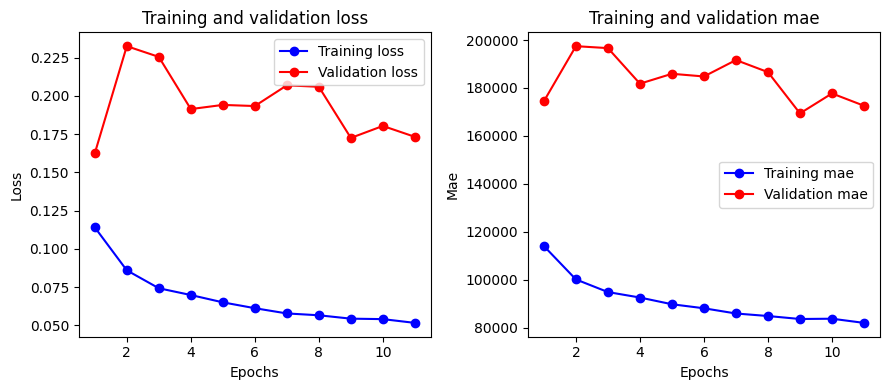

Best training MAE: 82048.31947512542
Best test MAE: 169403.94334678692


(<keras.src.engine.functional.Functional at 0x15157264dc90>,
 <keras.src.callbacks.History at 0x1515707bddd0>)

In [17]:
# LSTM 64 and 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64,64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 2, 64)             4544      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12865 (50.25 KB)
Trainable params: 12865 (50.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 35s 7ms/step - loss: 0.1212 - mae: 0.2241 - val_loss: 0.3124 - val_mae: 0.4551
Epoch 2/50
4905/490

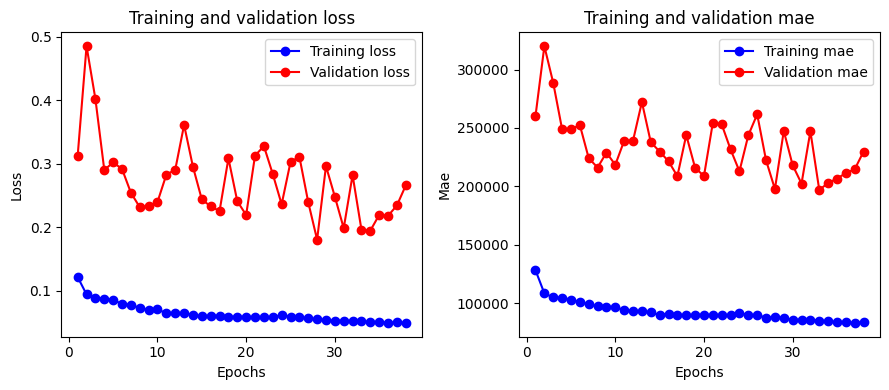

Best training MAE: 83045.30308390719
Best test MAE: 196973.8263690468


(<keras.src.engine.functional.Functional at 0x151535f64ed0>,
 <keras.src.callbacks.History at 0x151535f3cb10>)

In [18]:
# RNN 64 and 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 gru_5 (GRU)                 (None, 2, 64)             13824     
                                                                 
 gru_6 (GRU)                 (None, 64)                24960     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38849 (151.75 KB)
Trainable params: 38849 (151.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 25s 5ms/step - loss: 0.1060 - mae: 0.1948 - val_loss: 0.1683 - val_mae: 0.3151
Epoch 2/50
4905/4

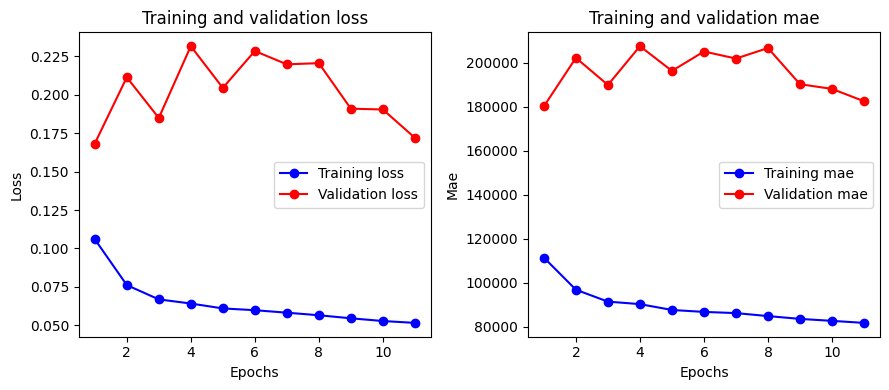

Best training MAE: 81692.92160530208
Best test MAE: 180189.21674140854


(<keras.src.engine.functional.Functional at 0x1515703d9090>,
 <keras.src.callbacks.History at 0x151534772190>)

In [19]:
# GRU 64 and 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Experiment: Parameter variations (learning rate, optimizer...)

The best outcome achieved with these initial models was the 2 stacked LSTM (32,32) with a test MAE of 88047. Below numerous runs were conducted with variations in model hyperparameters, including modifications to learning rates, utilization of learning rate schedulers, experimentation with different optimization algorithms, and integration of more complex hidden dense layer classifiers. Despite these adjustments, no improvement was observed except for the use of Adam optimizer which reduced the test MAE until around 80000.

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 32)             4992      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13345 (52.13 KB)
Trainable params: 13345 (52.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 26s 5ms/step - loss: 0.1110 - mae: 0.1971 - val_loss: 0.4670 - val_mae: 0.5044
Epoch 2/50
4905/4905

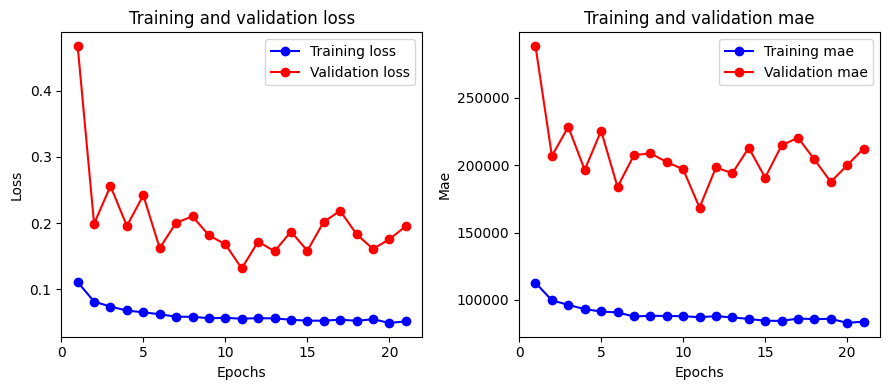

Best training MAE: 82995.63242470848
Best test MAE: 168593.0393717197


(<keras.src.engine.functional.Functional at 0x153a884233d0>,
 <keras.src.callbacks.History at 0x153a8836ec90>)

In [19]:
# Higher learning rate
hyperparameters = {
    "epochs": 50,
    "lr": 0.01,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "hidden_layer": None,
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 2, 32)             4992      
                                                                 
 lstm_9 (LSTM)               (None, 32)                8320      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13345 (52.13 KB)
Trainable params: 13345 (52.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 27s 5ms/step - loss: 0.1246 - mae: 0.2106 - val_loss: 0.1565 - val_mae: 0.2950
Epoch 2/50
4905/490

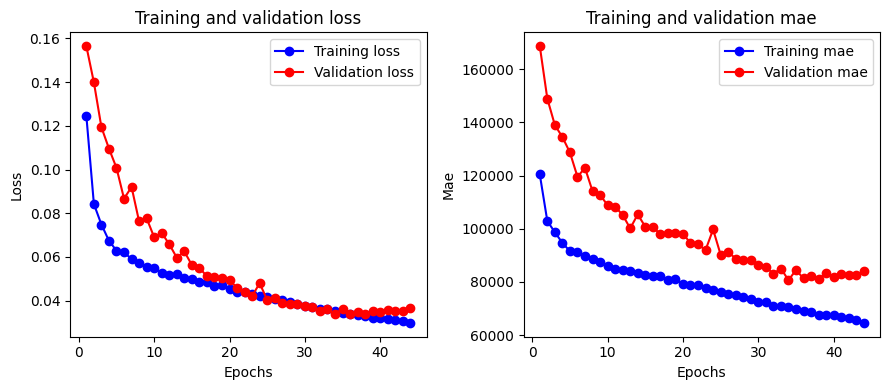

Best training MAE: 64586.952441717534
Best test MAE: 80665.34652859729


(<keras.src.engine.functional.Functional at 0x1535e1ac9810>,
 <keras.src.callbacks.History at 0x15359b876c90>)

In [22]:
# Using Adam
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2, 6)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 2, 32)             4992      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14401 (56.25 KB)
Trainable params: 14401 (56.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [

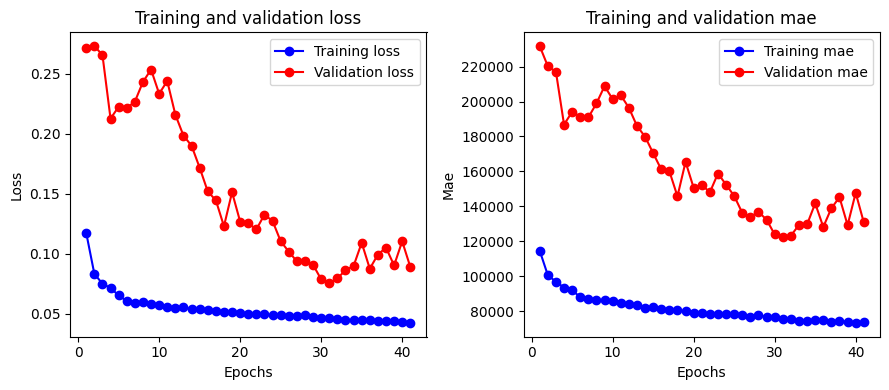

Best training MAE: 73231.46643989651
Best test MAE: 122449.24409383339


(<keras.src.engine.functional.Functional at 0x1535ec8d8510>,
 <keras.src.callbacks.History at 0x1535ec7aaa10>)

In [21]:
# dense hidden layer 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "dropout": (0.,0.,0.),
    "hidden_layer": 32,
    "weight_regularization": (0.,0.),
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Experiment: Different sequence lengths

Since we previously saw very early overtraining in most of the executions and high validation MAE values we decided to test to augment the sequence length hence increasing the number of features and, consequently, the complexity.
Recall that we cannot set a very large sequence size, since the test set will run out of samples to generate sequences (at 20%).

- Sequence length: 4

In [23]:
# Sequence length can be modified
seqLength = 4

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

print(f"{stdSales=}")
print(f"{nFeatures=}")

stdSales=571854.7800576452
nFeatures=6


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 4, 6)]            0         
                                                                 
 gru_10 (GRU)                (None, 64)                13824     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13889 (54.25 KB)
Trainable params: 13889 (54.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4725/4725 [==============================] - 18s 4ms/step - loss: 0.1139 - mae: 0.1986 - val_loss: 0.1464 - val_mae: 0.2687
Epoch 2/100
4725/4725 [==============================] - 16s 3ms/step - loss: 0.0668 - mae: 0.1628 - val_loss: 0.1606 - val_mae: 0.2904
Epoch 3/100
47

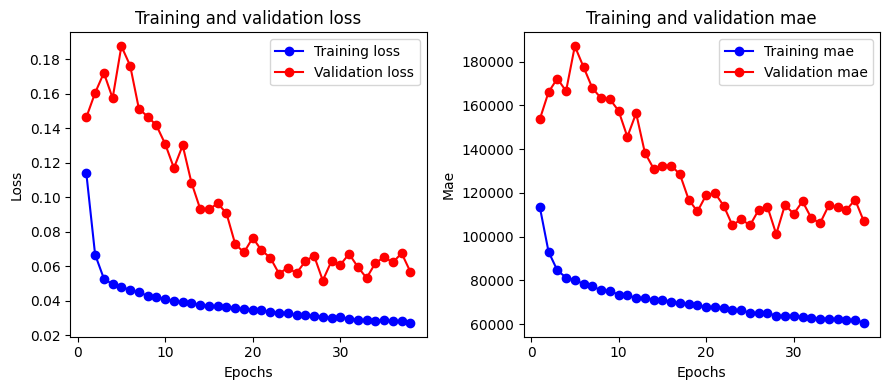

Best training MAE: 60578.48167297085
Best test MAE: 101129.93080007056


(<keras.src.engine.functional.Functional at 0x151507de9150>,
 <keras.src.callbacks.History at 0x15150c30aad0>)

In [24]:
# GRU 64
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

- Sequence length: 8

In [25]:
# Sequence length can be modified
seqLength = 8

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

print(f"{stdSales=}")
print(f"{nFeatures=}")

stdSales=571854.7800576452
nFeatures=6


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 gru_11 (GRU)                (None, 128)               52224     
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4365/4365 [==============================] - 17s 4ms/step - loss: 0.0915 - mae: 0.1902 - val_loss: 0.1986 - val_mae: 0.3452
Epoch 2/100
4365/4365 [==============================] - 16s 4ms/step - loss: 0.0406 - mae: 0.1353 - val_loss: 0.1453 - val_mae: 0.2886
Epoch 3/100


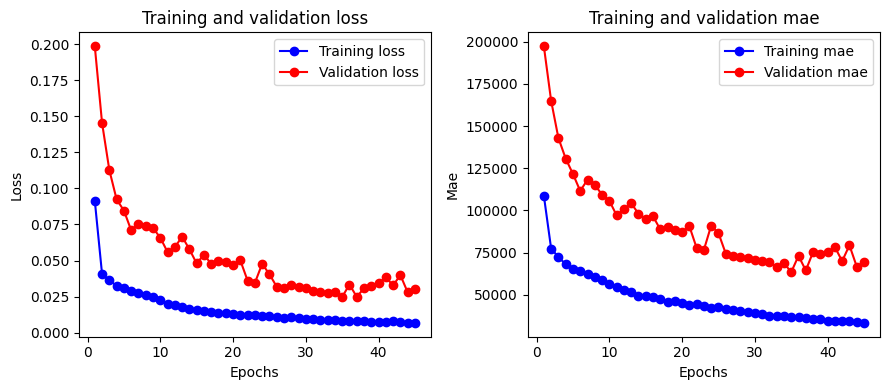

Best training MAE: 33275.24291770639
Best test MAE: 63356.86014310224


(<keras.src.engine.functional.Functional at 0x15150c2a75d0>,
 <keras.src.callbacks.History at 0x151506e9a190>)

In [26]:
# GRU 128
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

- Sequence length: 12

In [6]:
# Sequence length can be modified
seqLength = 12

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

print(f"{stdSales=}")
print(f"{nFeatures=}")

stdSales=571854.7800576452
nFeatures=6


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_12 (GRU)                (None, 128)               52224     
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 16s 4ms/step - loss: 0.0934 - mae: 0.1892 - val_loss: 0.1222 - val_mae: 0.2719
Epoch 2/100
4005/4005 [==============================] - 14s 3ms/step - loss: 0.0420 - mae: 0.1354 - val_loss: 0.0842 - val_mae: 0.2072
Epoch 3/100


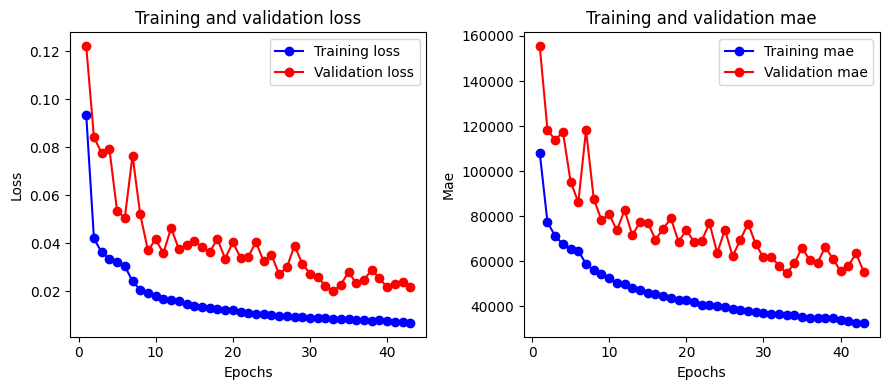

Best training MAE: 32698.482970453944
Best test MAE: 54643.97123166021


(<keras.src.engine.functional.Functional at 0x151505da87d0>,
 <keras.src.callbacks.History at 0x15150549ee90>)

In [28]:
# GRU 128
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

In experimenting with different sequence lengths, the most favorable outcomes emerged with a sequence size of 12, yielding 4 sequences per store amounting to 180 samples. This size essentially represents the maximum sequence size feasible given the volume of data to be analyzed per store.

For our second approximation we will use a sequence length of 12 and repeat the previous trial and error tests examining various networks ranging from simple to complex ones.

#### Training and evaluating a densely connected model

* Same as before, it is useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.
* The following listing shows a fully connected model that starts by flattening the data and then runs it through two `Dense` layers. 
* Note the lack of an activation function on the last `Dense` layer, which is typical for a regression problem. 
* We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it is smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in `compile()`.

In [13]:
# Sequence length can be modified
seqLength = 12

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

print(f"{stdSales=}")
print(f"{nFeatures=}")

stdSales=571854.7800576452
nFeatures=6


In [11]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ # Save the best performing model
    keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + "/walmart_dense_12.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

# Reload the best modle and evaluate it on the test data
model = keras.models.load_model("walmart_dense_12.keras")
print(f"Test MAE: {model.evaluate(testData)[1]*stdSales:.2f}")

Epoch 1/10
4005/4005 [==============================] - 20s 5ms/step - loss: 0.1324 - mae: 0.2423 - val_loss: 0.0988 - val_mae: 0.2556
Epoch 2/10
4005/4005 [==============================] - 20s 5ms/step - loss: 0.0607 - mae: 0.1660 - val_loss: 0.0305 - val_mae: 0.1384
Epoch 3/10
4005/4005 [==============================] - 19s 5ms/step - loss: 0.0497 - mae: 0.1490 - val_loss: 0.0429 - val_mae: 0.1602
Epoch 4/10
4005/4005 [==============================] - 20s 5ms/step - loss: 0.0449 - mae: 0.1413 - val_loss: 0.0343 - val_mae: 0.1273
Epoch 5/10
4005/4005 [==============================] - 19s 5ms/step - loss: 0.0433 - mae: 0.1384 - val_loss: 0.0383 - val_mae: 0.1343
Epoch 6/10
4005/4005 [==============================] - 20s 5ms/step - loss: 0.0412 - mae: 0.1338 - val_loss: 0.0392 - val_mae: 0.1534
Epoch 7/10
4005/4005 [==============================] - 20s 5ms/step - loss: 0.0394 - mae: 0.1331 - val_loss: 0.0494 - val_mae: 0.1588
Epoch 8/10
4005/4005 [==============================] -

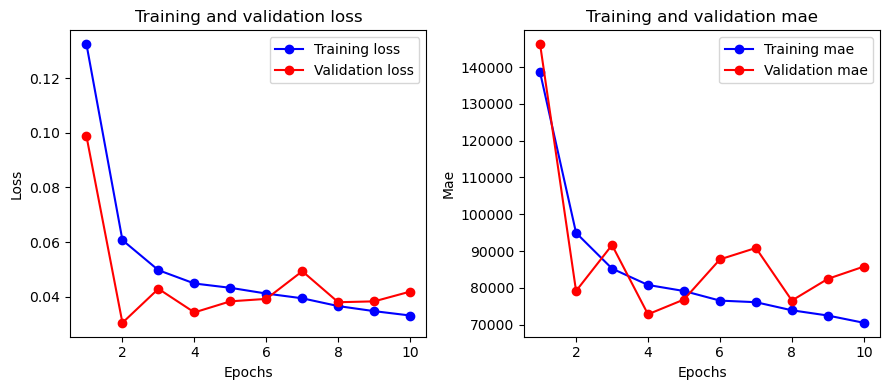

In [12]:
plot_results(history, stdSales)

The network trained using a sequence length of 12 exhibits notable improvements compared to the previous densely connected network. Upon evaluation on the test set, the network presents a reduced MAE of approximately 79144.37, significantly better than the previous network's performance. However, despite these improvements, the expected test MAE of 68,000 is not reached. Nonetheless, the performance improvement signifies the potential of using more data to improve the model generalization.

## APPROXIMATION 2: Using a sequence length of 12

Again, models employing simple RNN recurrent units demonstrated notably lower performance compared to others. However, in this case GRUs showed better results than LSTMs. Specifically, the best outcome achieved with these initial models was with the 64-neuron GRU, reaching MAE values close to 55,000 in the test set.

Regarding 1 RNN models, despite executing more complex models, no improvement in results was observed. This suggests that the complexity of these models aligns with the complexity of the problem at hand. On the other hand, experiments with increasingly cell units in models with two recurrent GRU layers exhibited that an architecture with only one recurrent layer was not complex enough to handle this regression problem. The run with a sequence size of 12 confirmed that the **best model** is a **GRU with two stacked recurrent units of 256 neurons each**. This network consistently achieved the lowest values, with a minimum MAE in validation of 51,089.21. Although other architectures with GRU and this sequence size were tested, for clarity and simplicity, only four runs with an incrementally stacked recurrent memory size were presented.

Furthermore, numerous runs were conducted with variations in model hyperparameters, including modifications to learning rates, utilization of learning rate schedulers, experimentation with different optimization algorithms, and integration of more complex hidden dense layer classifiers. Despite these adjustments, no improvement was observed. Unlike the previous approach Adam did not reduce the test MAE.

### Single RNN (16 units)
- Best test MAE: 55974 (GRU)
- No overtraining

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1472      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1489 (5.82 KB)
Trainable params: 1489 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 16s 4ms/step - loss: 0.1327 - mae: 0.2099 - val_loss: 0.1805 - val_mae: 0.3305
Epoch 2/50
4005/4005 [==============================] - 14s 3ms/step - loss: 0.0864 - mae: 0.1722 - val_loss: 0.1231 - val_mae: 0.2768
Epoch 3/50
4005/4005 

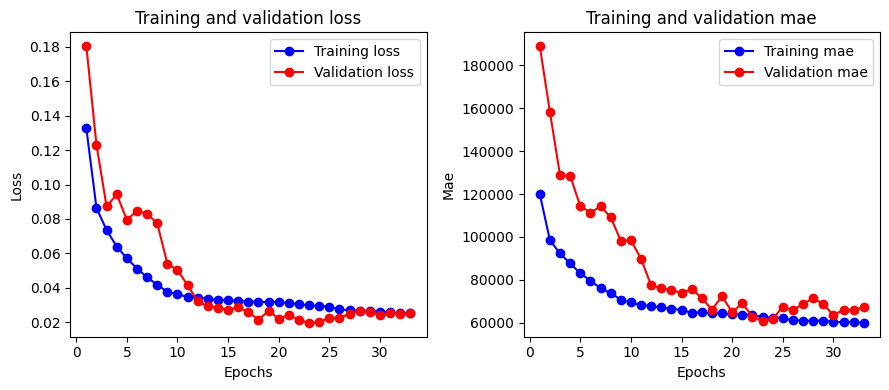

Best training MAE: 59942.79693444048
Best test MAE: 60826.10639779238


(<keras.src.engine.functional.Functional at 0x153a88132dd0>,
 <keras.src.callbacks.History at 0x153a13c8f2d0>)

In [14]:
# LSTM 16
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [16],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                368       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 30s 7ms/step - loss: 0.1508 - mae: 0.2350 - val_loss: 0.2420 - val_mae: 0.3963
Epoch 2/50
4005/4005 [==============================] - 29s 7ms/step - loss: 0.1078 - mae: 0.1971 - val_loss: 0.1240 - val_mae: 0.2767
Epoch 3/50
4005/4005 [=

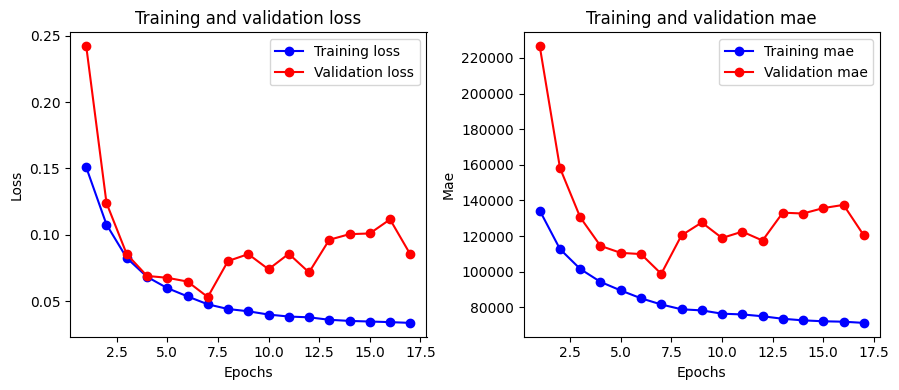

Best training MAE: 71300.6761424392
Best test MAE: 98837.05341208809


(<keras.src.engine.functional.Functional at 0x153a8890bdd0>,
 <keras.src.callbacks.History at 0x153a24177e10>)

In [15]:
# RNN 16
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_3 (GRU)                 (None, 16)                1152      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 15s 3ms/step - loss: 0.1240 - mae: 0.2065 - val_loss: 0.1155 - val_mae: 0.2672
Epoch 2/50
4005/4005 [==============================] - 13s 3ms/step - loss: 0.0735 - mae: 0.1603 - val_loss: 0.0923 - val_mae: 0.2320
Epoch 3/50
4005/4005 

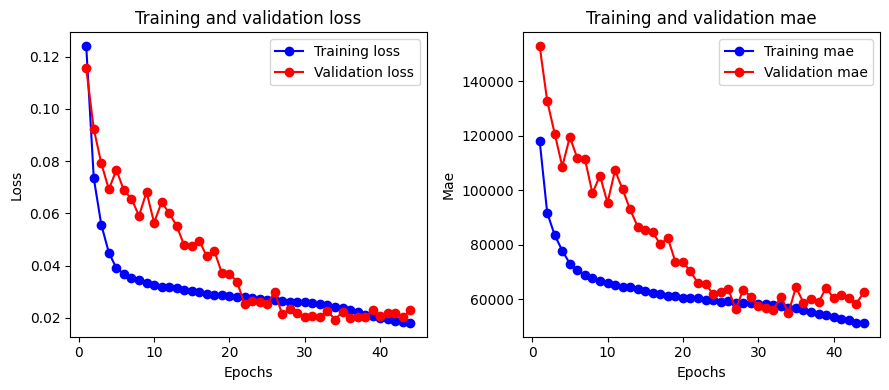

Best training MAE: 51340.680665690765
Best test MAE: 54974.35908522893


(<keras.src.engine.functional.Functional at 0x15368116d510>,
 <keras.src.callbacks.History at 0x153a8008fe10>)

In [16]:
# GRU 16
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (32 units)
- Best test MAE: 55662 (LSTM)
- No overtraining

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5025 (19.63 KB)
Trainable params: 5025 (19.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-03-09 18:30:18.063889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-09 18:30:18.902038: I external/local_xla/xla/service/service.cc:168] XLA service 0x14bb1b42ec90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 18:30:18.902060: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-09 18:30:18.906908: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710005418.991406  487798 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4005/4005 [==============================] - 18s 4ms/step - loss: 0.1180 - mae: 0.1955 - val_loss: 0.1902 - val_mae: 0.3324
Epoch 2/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0829 - mae: 0.1630 - val_loss: 0.1074 - val_mae: 0.2543
Epoch 3/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0646 - mae: 0.1474 - val_loss: 0.0661 - val_mae: 0.1925
Epoch 4/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0538 - mae: 0.1387 - val_loss: 0.0560 - val_mae: 0.1826
Epoch 5/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0459 - mae: 0.1322 - val_loss: 0.0448 - val_mae: 0.1496
Epoch 6/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0393 - mae: 0.1236 - val_loss: 0.0536 - val_mae: 0.1655
Epoch 7/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0359 - mae: 0.1189 - val_loss: 0.0451 - val_mae: 0.1531
Epoch 8/50
4005/4005 [==============================] - 14s 4ms/st

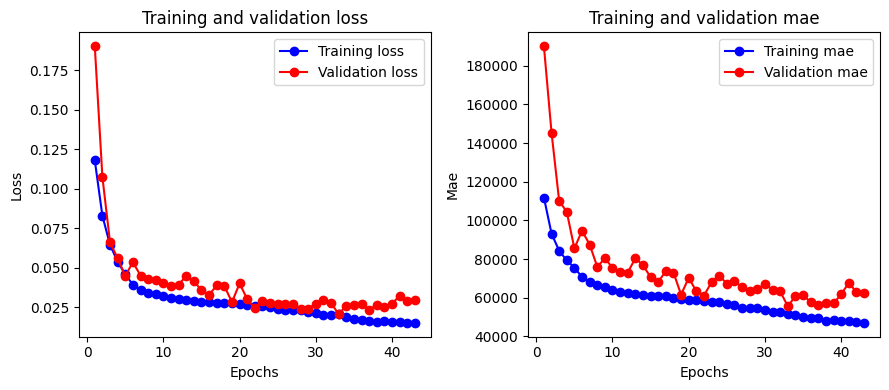

Best training MAE: 47032.61376185444
Best test MAE: 55662.60746439529


(<keras.src.engine.functional.Functional at 0x14bb418ac410>,
 <keras.src.callbacks.History at 0x14bb432ea790>)

In [7]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1248      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 31s 7ms/step - loss: 0.1172 - mae: 0.2145 - val_loss: 0.1807 - val_mae: 0.3355
Epoch 2/50
4005/4005 [==============================] - 30s 7ms/step - loss: 0.0789 - mae: 0.1801 - val_loss: 0.0756 - val_mae: 0.2200
Epoch 3/50
4005/4005 

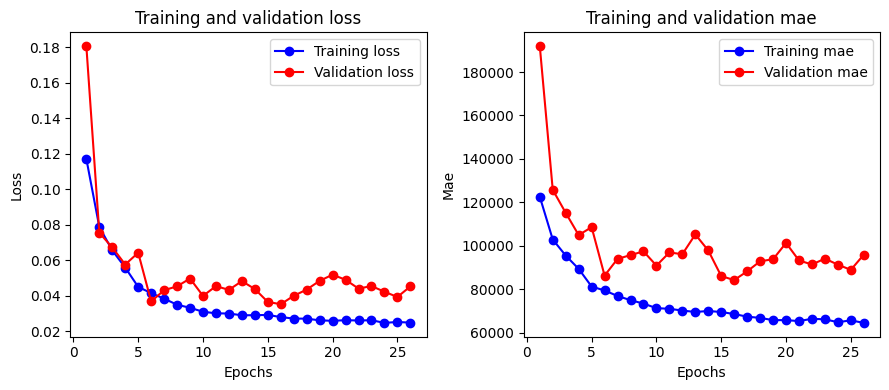

Best training MAE: 64645.289263277715
Best test MAE: 84329.01140374022


(<keras.src.engine.functional.Functional at 0x14bbafbcd0d0>,
 <keras.src.callbacks.History at 0x14bb8c40b450>)

In [8]:
# RNN 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 32)                3840      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3873 (15.13 KB)
Trainable params: 3873 (15.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 15s 3ms/step - loss: 0.1113 - mae: 0.1953 - val_loss: 0.1458 - val_mae: 0.2862
Epoch 2/50
4005/4005 [==============================] - 14s 3ms/step - loss: 0.0591 - mae: 0.1521 - val_loss: 0.0789 - val_mae: 0.2004
Epoch 3/50
4005/400

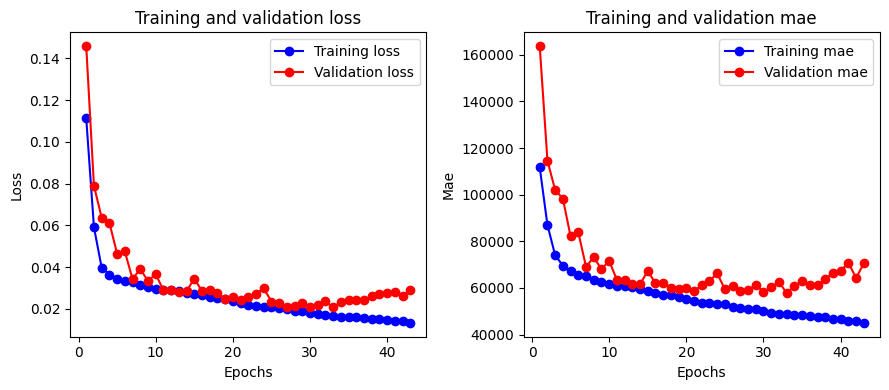

Best training MAE: 45008.15733197097
Best test MAE: 57751.66387152792


(<keras.src.engine.functional.Functional at 0x14bb2f9bea50>,
 <keras.src.callbacks.History at 0x14bb2f1f2190>)

In [9]:
# GRU 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (64 units)
- Best test MAE: 55487 (GRU)
- Slight overtraining from epoch 12

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 16s 4ms/step - loss: 0.1059 - mae: 0.1877 - val_loss: 0.1710 - val_mae: 0.3304
Epoch 2/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0568 - mae: 0.1466 - val_loss: 0.0986 - val_mae: 0.2382
Epoch 3/50
4005/4

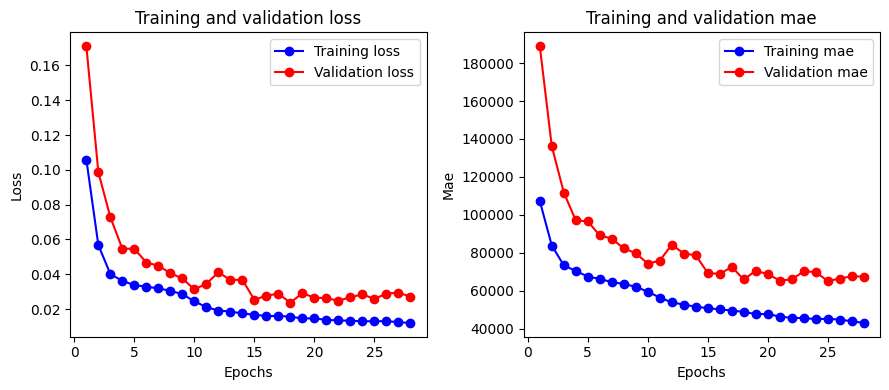

Best training MAE: 43078.25751039054
Best test MAE: 65127.10488306543


(<keras.src.engine.functional.Functional at 0x14bb2e03f510>,
 <keras.src.callbacks.History at 0x14bb2ed86f90>)

In [10]:
# LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4544      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 31s 7ms/step - loss: 0.1056 - mae: 0.2108 - val_loss: 0.2459 - val_mae: 0.4159
Epoch 2/50
4005/4005 [==============================] - 30s 7ms/step - loss: 0.0737 - mae: 0.1827 - val_loss: 0.1855 - val_mae: 0.3577
Epoch 3/50
4005/400

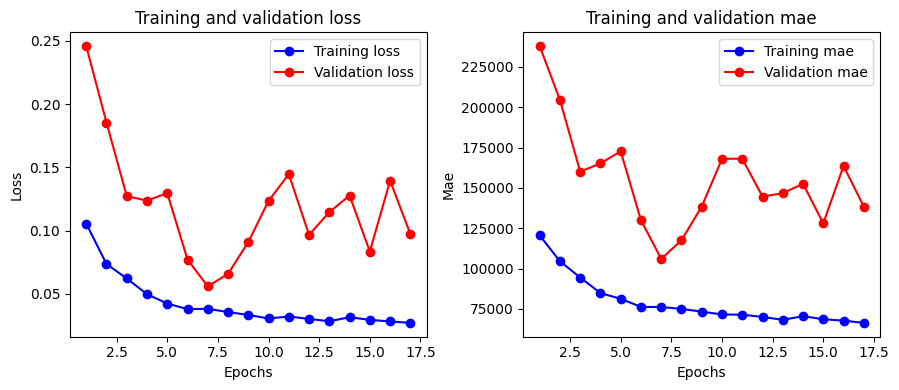

Best training MAE: 66288.18743154852
Best test MAE: 105965.78573858173


(<keras.src.engine.functional.Functional at 0x14bb2edd5650>,
 <keras.src.callbacks.History at 0x14bb2f03c5d0>)

In [11]:
# RNN 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13889 (54.25 KB)
Trainable params: 13889 (54.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 15s 3ms/step - loss: 0.1015 - mae: 0.1916 - val_loss: 0.0547 - val_mae: 0.1689
Epoch 2/50
4005/4005 [==============================] - 14s 3ms/step - loss: 0.0433 - mae: 0.1358 - val_loss: 0.0514 - val_mae: 0.1559
Epoch 3/50
4005/4

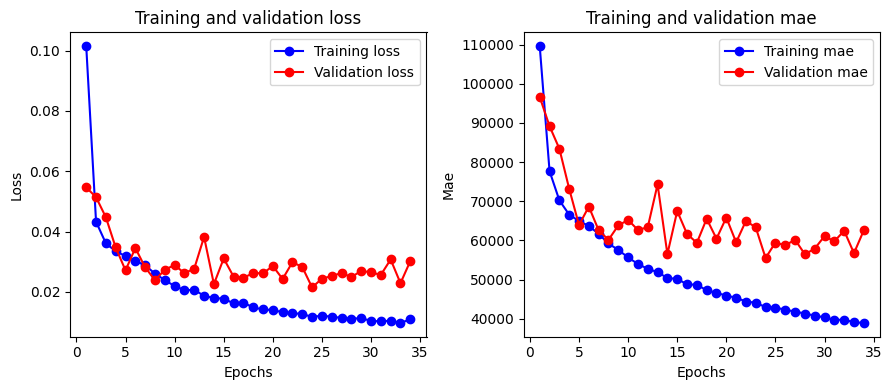

Best training MAE: 38928.780525639304
Best test MAE: 55487.71203726821


(<keras.src.engine.functional.Functional at 0x14bb8c553510>,
 <keras.src.callbacks.History at 0x14bb8c3ba490>)

In [12]:
# GRU 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Single RNN (128 units)
- Best test MAE: 58608 (GRU)
- No overtraining

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               69120     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69249 (270.50 KB)
Trainable params: 69249 (270.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 16s 4ms/step - loss: 0.1047 - mae: 0.1916 - val_loss: 0.1180 - val_mae: 0.2578
Epoch 2/50
4005/4005 [==============================] - 14s 4ms/step - loss: 0.0462 - mae: 0.1385 - val_loss: 0.1073 - val_mae: 0.2507
Epoch 3/50
4005

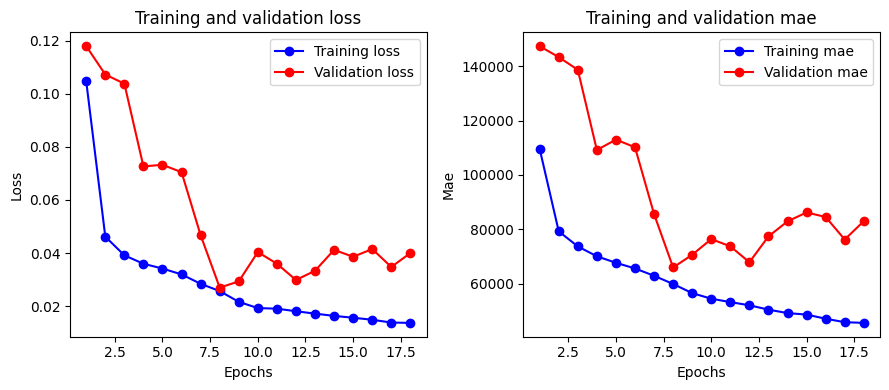

Best training MAE: 45494.74487990267
Best test MAE: 65901.25649012373


(<keras.src.engine.functional.Functional at 0x14bb432a7cd0>,
 <keras.src.callbacks.History at 0x14bba00c1510>)

In [13]:
# LSTM 128
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               17280     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 17409 (68.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 30s 7ms/step - loss: 0.1409 - mae: 0.2503 - val_loss: 0.2416 - val_mae: 0.4019
Epoch 2/50
4005/4005 [==============================] - 30s 7ms/step - loss: 0.1125 - mae: 0.2194 - val_loss: 0.2177 - val_mae: 0.3726
Epoch 3/50
4005/4

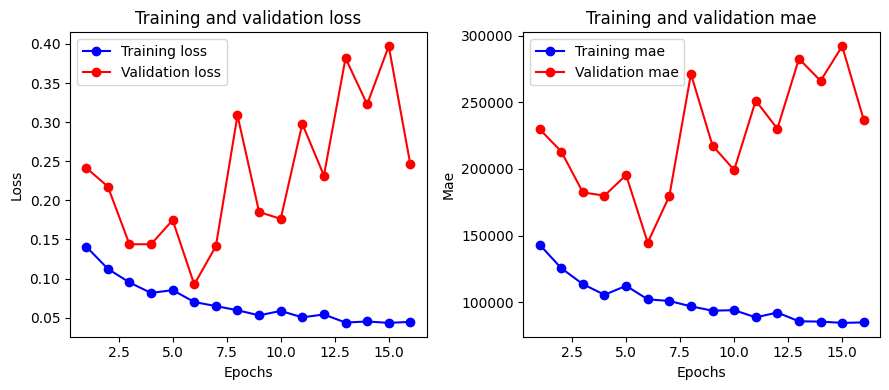

Best training MAE: 84406.1462136676
Best test MAE: 144663.31947849368


(<keras.src.engine.functional.Functional at 0x14bb2c129850>,
 <keras.src.callbacks.History at 0x14bb2c716f90>)

In [14]:
# RNN 128
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_2 (GRU)                 (None, 128)               52224     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 15s 3ms/step - loss: 0.0951 - mae: 0.1881 - val_loss: 0.0894 - val_mae: 0.2226
Epoch 2/50
4005/4005 [==============================] - 14s 3ms/step - loss: 0.0423 - mae: 0.1346 - val_loss: 0.0369 - val_mae: 0.1308
Epoch 3/50
4005

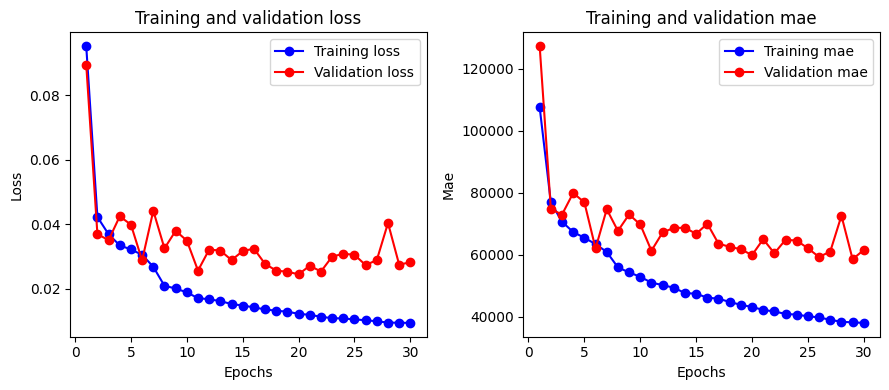

Best training MAE: 38078.542228585255
Best test MAE: 58608.02898346683


(<keras.src.engine.functional.Functional at 0x14b79ed34310>,
 <keras.src.callbacks.History at 0x14b79f0c6850>)

In [15]:
# GRU 128
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 stacked recurrent layers (32,32 units)
- Best test MAE: 70080 (GRU)
- No overtraining

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 12, 32)            4992      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13345 (52.13 KB)
Trainable params: 13345 (52.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 21s 5ms/step - loss: 0.1194 - mae: 0.1959 - val_loss: 0.2618 - val_mae: 0.4181
Epoch 2/50
4005/4005

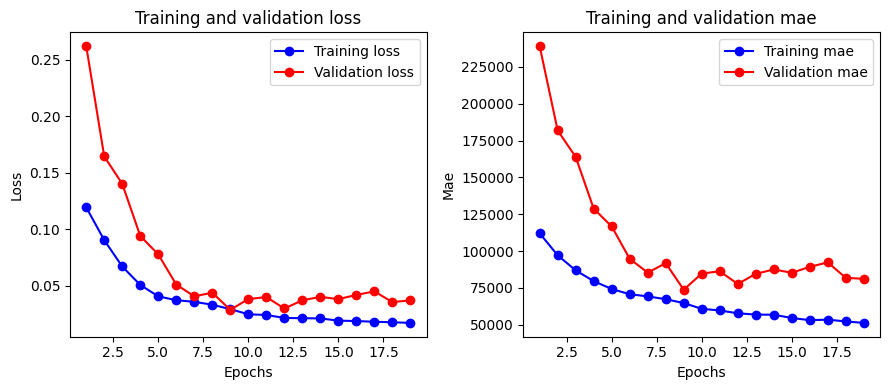

Best training MAE: 51230.94336097969
Best test MAE: 73755.56049090988


(<keras.src.engine.functional.Functional at 0x14bb2ed86b90>,
 <keras.src.callbacks.History at 0x14b79ecd78d0>)

In [16]:
# LSTM 32 and 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 12, 32)            1248      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3361 (13.13 KB)
Trainable params: 3361 (13.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 72s 18ms/step - loss: 0.1205 - mae: 0.2142 - val_loss: 0.2604 - val_mae: 0.4152
Epoch 2/50
4005/4005

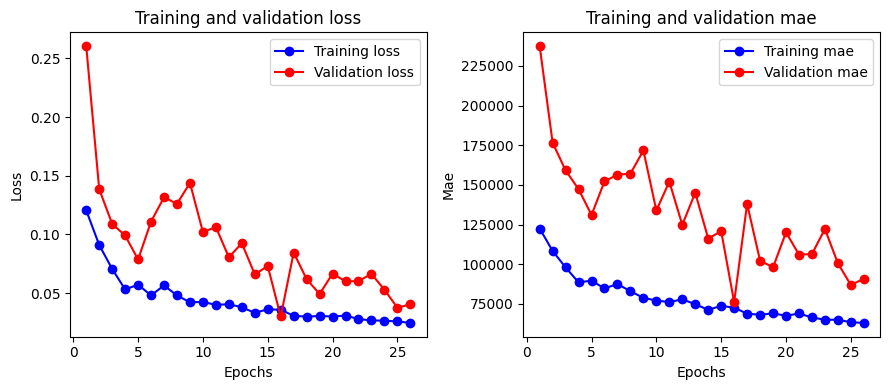

Best training MAE: 63014.738459079475
Best test MAE: 76086.29801593469


(<keras.src.engine.functional.Functional at 0x14b79d0820d0>,
 <keras.src.callbacks.History at 0x14b79d0da8d0>)

In [17]:
# RNN 32 and 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_3 (GRU)                 (None, 12, 32)            3840      
                                                                 
 gru_4 (GRU)                 (None, 32)                6336      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10209 (39.88 KB)
Trainable params: 10209 (39.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 20s 4ms/step - loss: 0.1061 - mae: 0.1954 - val_loss: 0.1338 - val_mae: 0.2815
Epoch 2/50
4005/400

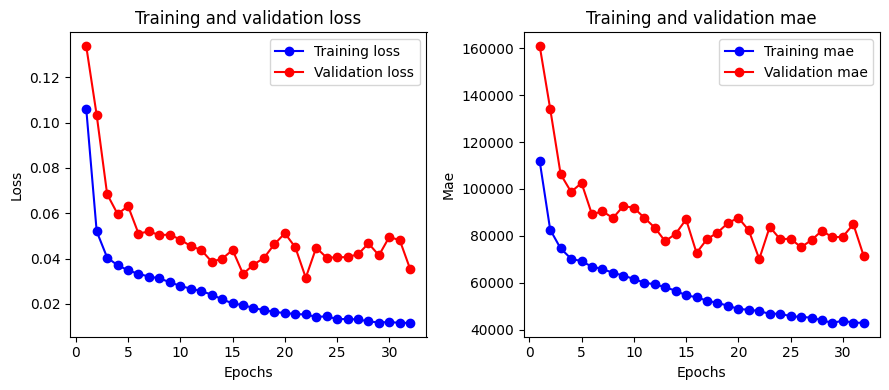

Best training MAE: 42834.173385825845
Best test MAE: 70080.1916098638


(<keras.src.engine.functional.Functional at 0x14b79d21c4d0>,
 <keras.src.callbacks.History at 0x14b79c5c0d10>)

In [18]:
# GRU 32 and 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 stacked recurrent layers (64,64 units)
- Best test MAE: 58668 (GRU)
- No overfitting

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 12, 64)            18176     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 51265 (200.25 KB)
Trainable params: 51265 (200.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 21s 5ms/step - loss: 0.1142 - mae: 0.1958 - val_loss: 0.2217 - val_mae: 0.3647
Epoch 2/50
4005/4

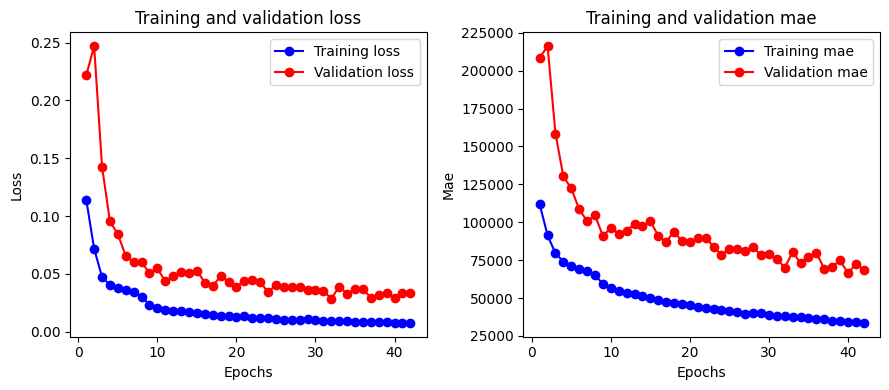

Best training MAE: 33600.20483333639
Best test MAE: 66443.80767749401


(<keras.src.engine.functional.Functional at 0x14b79d2790d0>,
 <keras.src.callbacks.History at 0x14b79c73efd0>)

In [19]:
# LSTM 64 and 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64,64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 12, 64)            4544      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12865 (50.25 KB)
Trainable params: 12865 (50.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 72s 18ms/step - loss: 0.1501 - mae: 0.2417 - val_loss: 0.3086 - val_mae: 0.4542
Epoch 2/50
4005/40

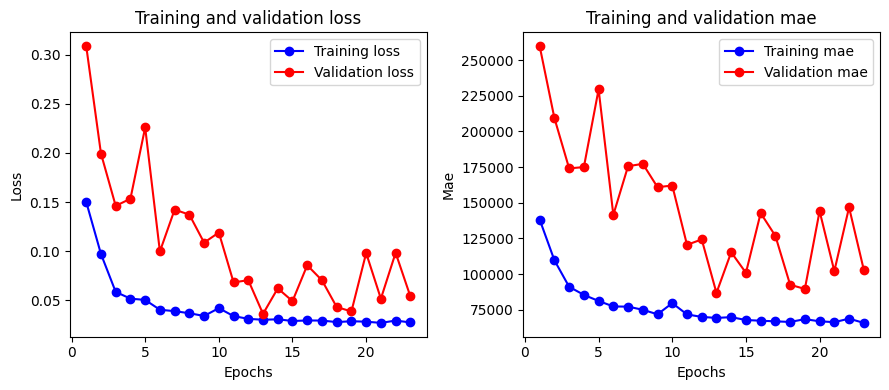

Best training MAE: 65839.09786539823
Best test MAE: 86840.08520610629


(<keras.src.engine.functional.Functional at 0x14b79d263f50>,
 <keras.src.callbacks.History at 0x14b75db60050>)

In [20]:
# RNN 64 and 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_5 (GRU)                 (None, 12, 64)            13824     
                                                                 
 gru_6 (GRU)                 (None, 64)                24960     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38849 (151.75 KB)
Trainable params: 38849 (151.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 20s 4ms/step - loss: 0.0981 - mae: 0.1924 - val_loss: 0.1660 - val_mae: 0.2978
Epoch 2/50
4005/4

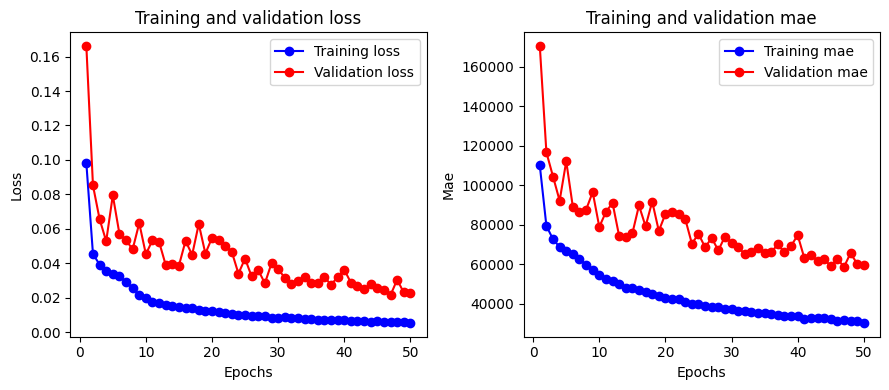

Best training MAE: 30431.175874218
Best test MAE: 58668.39813513833


(<keras.src.engine.functional.Functional at 0x14b75d024910>,
 <keras.src.callbacks.History at 0x14b75d07a950>)

In [21]:
# GRU 64 and 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Experiment: Parameter variations (learning rate, optimizer...)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_7 (GRU)                 (None, 64)                13824     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13889 (54.25 KB)
Trainable params: 13889 (54.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 19s 4ms/step - loss: 0.0936 - mae: 0.1846 - val_loss: 0.0795 - val_mae: 0.1927
Epoch 2/50
4005/4005 [==============================] - 16s 4ms/step - loss: 0.0414 - mae: 0.1358 - val_loss: 0.0479 - val_mae: 0.1464
Epoch 3/50
4005/

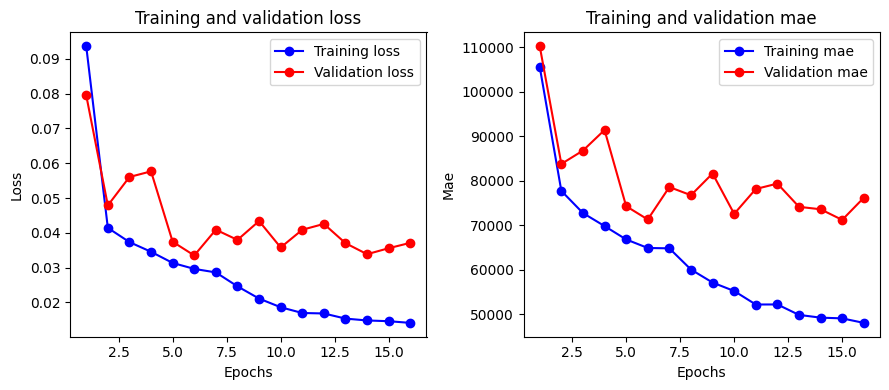

Best training MAE: 48003.360287144555
Best test MAE: 71158.48972634904


(<keras.src.engine.functional.Functional at 0x14b721aa3dd0>,
 <keras.src.callbacks.History at 0x14b721aa1150>)

In [22]:
# Using Adam
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_8 (GRU)                 (None, 64)                13824     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 15937 (62.25 KB)
Trainable params: 15937 (62.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4005/4005 [

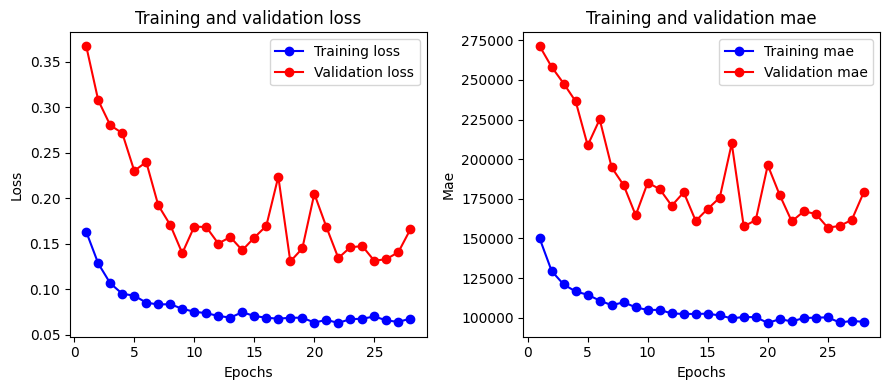

Best training MAE: 96780.39498853301
Best test MAE: 156812.9552998819


(<keras.src.engine.functional.Functional at 0x14b7217c6750>,
 <keras.src.callbacks.History at 0x14b7211793d0>)

In [23]:
# Dense hidden layer 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.2,0.2,0.2),
    "hidden_layer": 32,
    "weight_regularization": (0.,0.),
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Testing 2 GRU with 12 sequence length

For this experiment we will test different *cell_units* values using 2 GRU as they in average provided the best results. We will test [32,32], [64,64], [128,128] and [256,256].

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_13 (GRU)                (None, 12, 32)            3840      
                                                                 
 gru_14 (GRU)                (None, 32)                6336      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10209 (39.88 KB)
Trainable params: 10209 (39.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 20s 4ms/step - loss: 0.1057 - mae: 0.1948 - val_loss: 0.1558 - val_mae: 0.3062
Epoch 2/100
4005/4

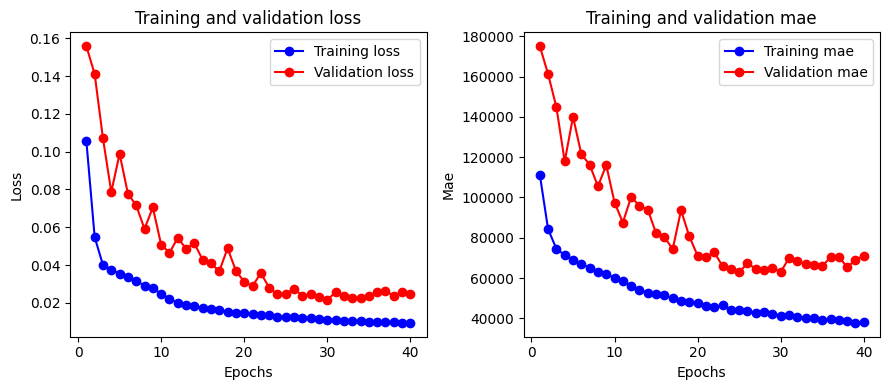

Best training MAE: 37777.02880093776
Best test MAE: 62830.22248396212


(<keras.src.engine.functional.Functional at 0x1519bc041ad0>,
 <keras.src.callbacks.History at 0x151505a5ff90>)

In [29]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [32,32],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_15 (GRU)                (None, 12, 64)            13824     
                                                                 
 gru_16 (GRU)                (None, 64)                24960     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38849 (151.75 KB)
Trainable params: 38849 (151.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 20s 4ms/step - loss: 0.1004 - mae: 0.1941 - val_loss: 0.1534 - val_mae: 0.3015
Epoch 2/100
4005

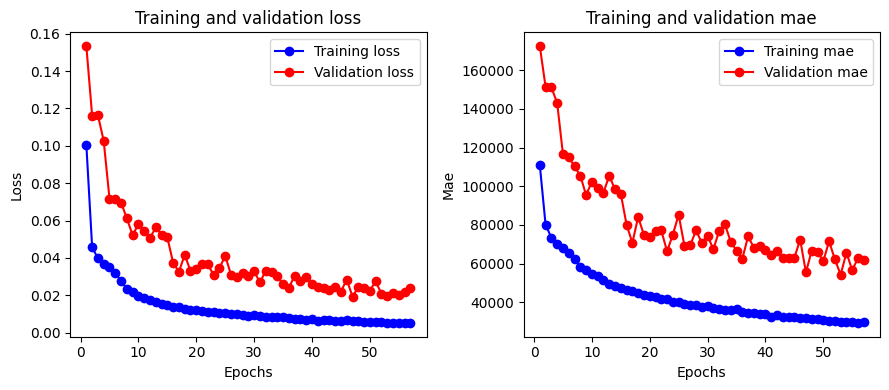

Best training MAE: 29368.759331086945
Best test MAE: 54237.31774079034


(<keras.src.engine.functional.Functional at 0x1519bc59e510>,
 <keras.src.callbacks.History at 0x15150c30af50>)

In [30]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64,64],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_17 (GRU)                (None, 12, 128)           52224     
                                                                 
 gru_18 (GRU)                (None, 128)               99072     
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 151425 (591.50 KB)
Trainable params: 151425 (591.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 20s 4ms/step - loss: 0.1030 - mae: 0.1980 - val_loss: 0.2607 - val_mae: 0.3872
Epoch 2/100
40

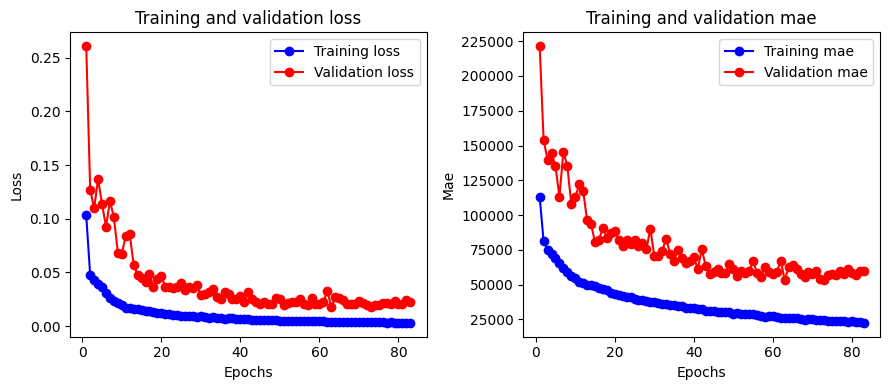

Best training MAE: 22456.07818163718
Best test MAE: 53097.82816715878


(<keras.src.engine.functional.Functional at 0x15150279fa50>,
 <keras.src.callbacks.History at 0x151502722950>)

In [31]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128,128],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_9 (GRU)                 (None, 12, 256)           202752    
                                                                 
 gru_10 (GRU)                (None, 256)               394752    
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 20s 4ms/step - loss: 0.1144 - mae: 0.2067 - val_loss: 0.1596 - val_mae: 0.2818
Epoch 2/100
4005/4

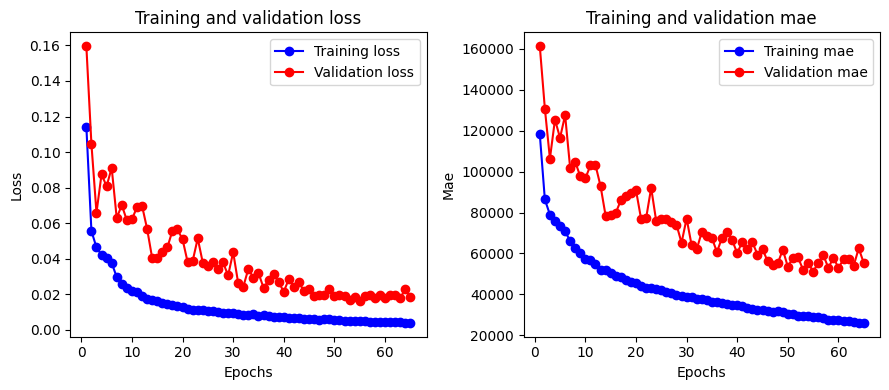

Best training MAE: 26132.49092196475
Best test MAE: 51089.21283445328


(<keras.src.engine.functional.Functional at 0x14b7210dbe10>,
 <keras.src.callbacks.History at 0x14b75e8c8f10>)

In [24]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

As we can see, the higher the *cell_units* values the higher the performance, reaching a test MAE of 51089 with [256,256]. Starting with the regularization process, we will try to reduce the difference between train and validation performance. That is, we will try to improve the inference capability by mitigating the overfitting to the training set. Since the best model in validation (GRU 256,256) is also the model with the lowest error in training, we will focus only on this one for the overfit mitigation stage.

## Overfitting mitigation

We aim to minimize the performance gap between the training and validation sets to mitigate overfitting, starting with the architecture exhibiting the best performance on the training set, which also coincides with the lowest error on the validation set. It is important to note that this configuration involves sequences of 12.

Regarding the proposed techniques, we will primarily employ dropout and weight regularization. Data augmentation techniques have not been taken into account as the available data is deemed more than adequate. Batch normalization is not utilized with this type of recurrent networks (https://arxiv.org/abs/1510.01378).

#### Dropout

We have explored dropout techniques for both input and recurrent states, as well as dropout before the final dense layer. However, dropout tends to introduce excessive noise into the network, potentially affecting its performance. In addition, training processes are notably slow due to the absence of cuDNN acceleration.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru (GRU)                   (None, 2, 256)            202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-03-10 00:08:19.339099: I external/local_xla/xla/service/service.cc:168] XLA service 0x14fa5e1dc8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 00:08:19.339122: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-10 00:08:19.343927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 00:08:19.360430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710025699.438656  519064 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4905/4905 [==============================] - 74s 14ms/step - loss: 0.1473 - mae: 0.2401 - val_loss: 0.5841 - val_mae: 0.6402
Epoch 2/50
4905/4905 [==============================] - 68s 14ms/step - loss: 0.1232 - mae: 0.2141 - val_loss: 0.5988 - val_mae: 0.6503
Epoch 3/50
4905/4905 [==============================] - 68s 14ms/step - loss: 0.1115 - mae: 0.2021 - val_loss: 0.5917 - val_mae: 0.6342
Epoch 4/50
4905/4905 [==============================] - 67s 14ms/step - loss: 0.0980 - mae: 0.1950 - val_loss: 0.4483 - val_mae: 0.5615
Epoch 5/50
4905/4905 [==============================] - 67s 14ms/step - loss: 0.0951 - mae: 0.1905 - val_loss: 0.4389 - val_mae: 0.5425
Epoch 6/50
4905/4905 [==============================] - 67s 14ms/step - loss: 0.0866 - mae: 0.1884 - val_loss: 0.3997 - val_mae: 0.5210
Epoch 7/50
4905/4905 [==============================] - 66s 14ms/step - loss: 0.0913 - mae: 0.1875 - val_loss: 0.2802 - val_mae: 0.4411
Epoch 8/50
4905/4905 [==============================] - 66s

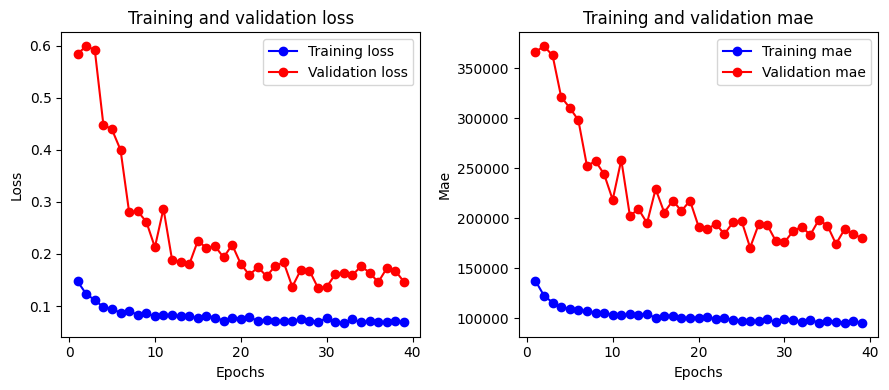

Best training MAE: 95184.25319477299
Best test MAE: 170474.98557610324


(<keras.src.engine.functional.Functional at 0x14fe2c10ea90>,
 <keras.src.callbacks.History at 0x14fde3114990>)

In [5]:
# GRU 256,256 - (lstm_dropout, recurrent_dropout, dense_dropout) = (0.1,0.1,0.1)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0.1,0.1,0.1),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_2 (GRU)                 (None, 2, 256)            202752    
                                                                 
 gru_3 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [=

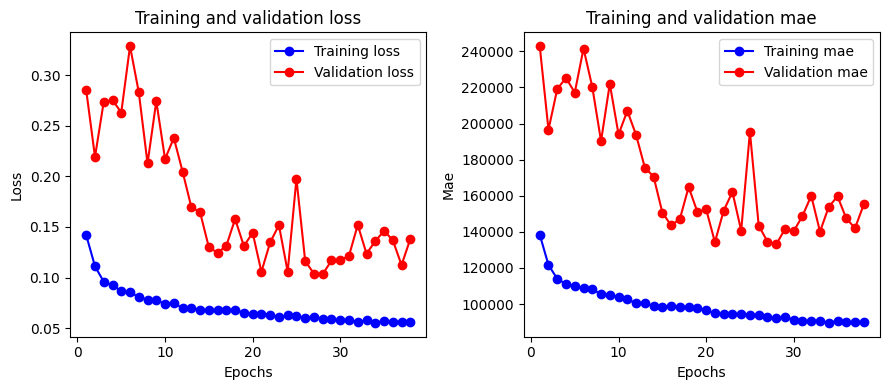

Best training MAE: 89540.21257597662
Best test MAE: 132979.30454575454


(<keras.src.engine.functional.Functional at 0x14fe4f9f6250>,
 <keras.src.callbacks.History at 0x14fdcded3c90>)

In [6]:
# GRU 256,256 - (lstm_dropout, recurrent_dropout, dense_dropout) = (0,0.05,0.5)
hyperparameters["dropout"] = (0,0.05,0.5)
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_4 (GRU)                 (None, 2, 256)            202752    
                                                                 
 gru_5 (GRU)                 (None, 256)               394752    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 67s 13ms/step - loss: 0.1200 - mae: 0.2064 - val_loss: 0.2699 - val_mae: 0.3935
Epoch 2/50
4905/490

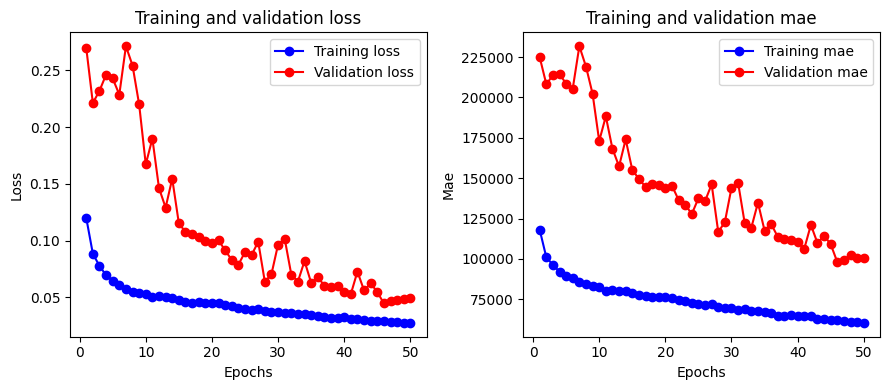

Best training MAE: 60320.997803751845
Best test MAE: 97963.13442161954


(<keras.src.engine.functional.Functional at 0x14fdcd6889d0>,
 <keras.src.callbacks.History at 0x14fdcd575d10>)

In [7]:
# GRU 256,256 - (lstm_dropout, recurrent_dropout, dense_dropout) = (0,0.05,0)
hyperparameters["dropout"] = (0,0.05,0)
execute_pipeline(trainData, testData, hyperparameters, stdSales)

We can see how the higher the dropout the higher the decrease on performance.

#### Weight regularization

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 6)]            0         
                                                                 
 gru_6 (GRU)                 (None, 2, 256)            202752    
                                                                 
 gru_7 (GRU)                 (None, 256)               394752    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
4905/4905 [==============================] - 26s 5ms/step - loss: 0.1457 - mae: 0.2106 - val_loss: 0.2954 - val_mae: 0.4410
Epoch 2/50
4905/4905

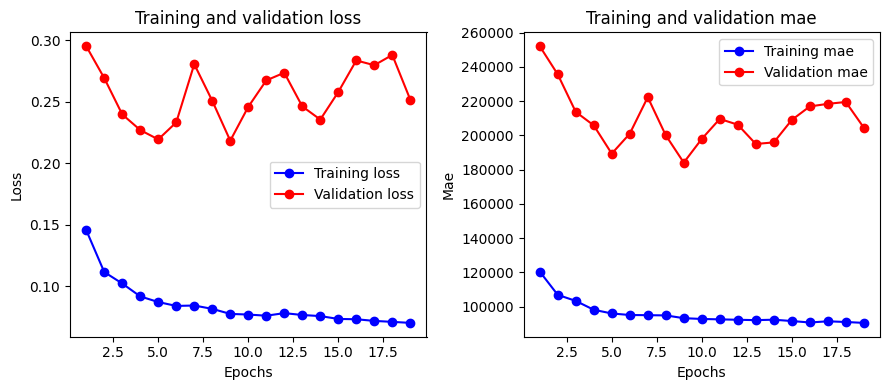

Best training MAE: 90429.503992109
Best test MAE: 184117.05896712246


(<keras.src.engine.functional.Functional at 0x14fdcc607ed0>,
 <keras.src.callbacks.History at 0x14f9e5d65dd0>)

In [8]:
# GRU 256,256 - L1,L2 regularization = (1e-5,1e-4)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0.,0.,0.),
    "weight_regularization": (1e-5,1e-4),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

#### Combining dropout + weight regularization

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 256)           202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597761 (2.28 MB)
Trainable params: 597761 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-03-26 14:27:08.574787: I external/local_xla/xla/service/service.cc:168] XLA service 0x1539fe7d7210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 14:27:08.574813: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-26 14:27:08.593614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 14:27:08.637578: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1711459628.720342  105036 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4005/4005 [==============================] - 199s 48ms/step - loss: 0.1465 - mae: 0.2127 - val_loss: 0.2639 - val_mae: 0.3570
Epoch 2/50
4005/4005 [==============================] - 191s 48ms/step - loss: 0.0765 - mae: 0.1611 - val_loss: 0.0790 - val_mae: 0.1983
Epoch 3/50
4005/4005 [==============================] - 190s 47ms/step - loss: 0.0596 - mae: 0.1467 - val_loss: 0.0957 - val_mae: 0.2296
Epoch 4/50
4005/4005 [==============================] - 189s 47ms/step - loss: 0.0534 - mae: 0.1395 - val_loss: 0.0916 - val_mae: 0.2256
Epoch 5/50
4005/4005 [==============================] - 189s 47ms/step - loss: 0.0520 - mae: 0.1381 - val_loss: 0.1426 - val_mae: 0.2947
Epoch 6/50
4005/4005 [==============================] - 189s 47ms/step - loss: 0.0476 - mae: 0.1336 - val_loss: 0.1147 - val_mae: 0.2553
Epoch 7/50
4005/4005 [==============================] - 189s 47ms/step - loss: 0.0412 - mae: 0.1224 - val_loss: 0.1036 - val_mae: 0.2368
Epoch 8/50
4005/4005 [==============================

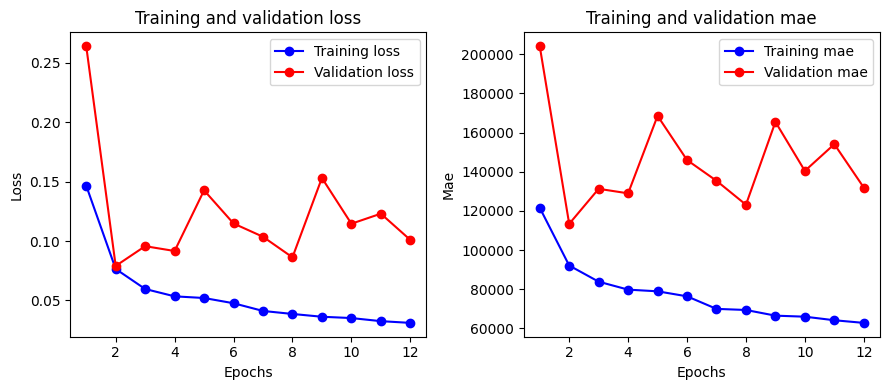

Best training MAE: 62821.54780030038
Best test MAE: 113387.16507980533


(<keras.src.engine.functional.Functional at 0x153a241421d0>,
 <keras.src.callbacks.History at 0x153a24350490>)

In [7]:
# GRU 256,256 - (lstm_dropout, recurrent_dropout, dense_dropout) = (0,0.05,0); L1,L2 regularization = (1e-5,1e-4)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0,0.05,0),
    "weight_regularization": (1e-5,1e-4),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

# 4. Results

From the various runs conducted, we started with simpler models and gradually moved towards more complex ones. Initially, we evaluated simpler architectures with a sequence size of 2. Models employing SimpleRNN recurrent units demonstrated notably lower performance compared to others. While GRUs showed slightly better performance for the biggest architecture tested (128 neurons in the recurrent cell), LSTMs consistently outperformed other models across subsequent runs. Specifically, the best outcome achieved with these initial models was the 2 stacked LSTM (32,32) with a test MAE of 88047. In general the MAE values were really high, surpassing the 100,000 due to the early overfitting problem as the model start to overtrain in the first epoch. Also note that the simplest (32,32) models with two stacked recurrent cells provided the best results in all the experiments.

Thus, different increasingly sequence sizes were tested over a GRU 128 model to increase the complexity of the problem with the aim to reduce this overtraining problem. Smaller sequences yielded worse results, while longer sequences, specifically almost the maximum allowed by the length of the test set (12) which reach a test MAE of 54643, led to the decision to use this sequence length and to repeat again the optimal architecture search experiments.

Again, models employing SimpleRNN recurrent units demonstrated notably lower performance compared to others. However, in this case GRUs showed better results than LSTMs. Specifically, the best outcome achieved with these initial models was with the 64-neuron GRU, reaching MAE values close to 55,000 in the test set.

Regarding 1 RNN models, despite executing more complex models, no improvement in results was observed. This suggests that the complexity of these models aligns with the complexity of the problem at hand. On the other hand, experiments with increasingly cell units in models with two recurrent GRU layers exhibited that an architecture with only one recurrent layer was not complex enough to handle this regression problem. The run with a sequence size of 12 confirmed that the best model is a GRU with two stacked recurrent units of 256 neurons each. This network consistently achieved the lowest values, with a minimum MAE in validation of 51,089.21.

Furthermore, numerous runs were conducted with variations in model hyperparameters, including modifications to learning rates, utilization of learning rate schedulers, experimentation with different optimization algorithms, and integration of more complex hidden dense layer classifiers. Despite these adjustments, no improvement was observed.

Transitioning to the regularization process, the aim was to reduce the disparity between train and validation performance to enhance inference capability by mitigating overfitting to the training set. As the best model in validation (GRU 256,256) also exhibited the lowest error in training, focus was solely on this model for the overfit mitigation stage.

Regrettably, the results obtained during the regularization phase were unsatisfactory. The techniques only led to a higher train error without improving the validation metrics, thus failing to enhance generalization capacity.

# 5. Conclusions

The key takeaway from the experiments is how the amount of data and the problem itself affect our findings. Looking at the learning graphs using a sequence length of 12, we see that the networks learn for a long time without overfitting, unlike what we observed when using a sequence length of 2 where overfitting happened too early because of the small amount of data.

Since there is no overfitting, the models learn during many epochs (more than 20 epochs in some cases). That is why the regularization techniques we tried did not improve the performance. The training was stable, and adding dropout and regularization introduced a greater difficulty.

Another thing to note is that as we increased the sequence length, the simple models with just one recurrent cell stopped being the best fit for the problem. With a sequence length of 12, more complicated models turned out to be better.

Lastly, we did not use bidirectional networks because they do not really fit our problem. In this case, data close to the end of the sequence is more important, so bidirectional networks would not help much.

To sum up, below final models are trained again and saved, and some plots with insights are commented.

In [ ]:
# TRAIN AND SAVE BEST MODELS FOR EACH ARCHITECTURE

# Sequence length can be modified
seqLength = 2

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

# LSTM 32 and 32
checkpoint_filename = "/lstm_32_32_seq2.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

# RNN 32 and 32
checkpoint_filename = "/srnn_32_32_seq2.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.SimpleRNN,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

# GRU 32 and 32
checkpoint_filename = "/gru_32_32_seq2.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


# Sequence length can be modified
seqLength = 12

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

# LSTM 32
checkpoint_filename = "/lstm_32_32_seq12.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


# RNN 32 and 32
checkpoint_filename = "/srnn_32_32_seq12.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.SimpleRNN,
    "cell_units": [32,32],
    "weight_regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


# GRU 64
checkpoint_filename = "/gru_64_seq12.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


# GRU 256,256
checkpoint_filename = "/gru_256_256_seq12.keras"
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0,0,0),
    "weight_regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": callbacks.EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


# GRU 256,256 - even less dropout
checkpoint_filename = "/gru_256_256_seq12_lowdropout.keras"
hyperparameters["dropout"] = (0,0.05,0)
hyperparameters["checkpoint"] = callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
execute_pipeline(trainData, testData, hyperparameters, stdSales)

In [21]:
def metric_comparison_plot(model_names, metric_name, test):
    num_models = len(test)

    # Plot the results
    plt.figure(figsize=(14, 6))
    bar_width = 0.35
    index = np.arange(num_models)

    plt.bar(index + bar_width, test, bar_width, label='Test '+metric_name)

    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title('Walmart Sales prediction results')
    plt.xticks(index + bar_width / 2, [label.replace('_', '_\n') for label in model_names])
    plt.legend()

    plt.tight_layout()
    plt.show()

180/180 [==============================] - 3s 13ms/step - loss: 0.0587 - mae: 0.1930


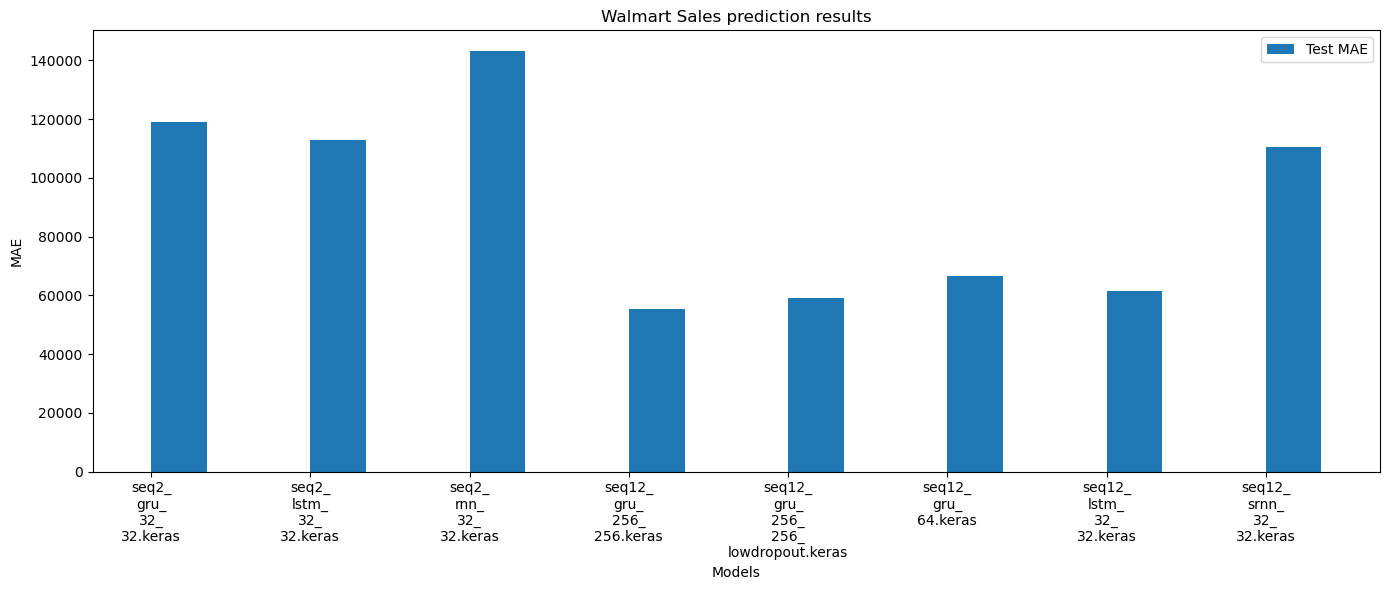

In [27]:
# Reserve memory
model_names, test_maes = [], []

# Sequence length can be modified
seqLength = 2

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

# Get model names
models2 = [f for f in os.listdir(OUT_MODELS_FOLDER) if f.endswith('.keras') and f.startswith('seq2')]

# Get results
for model in models2:
    test_model = keras.models.load_model(OUT_MODELS_FOLDER+"/"+model)
    test_mae = test_model.evaluate(testData)[1]

    model_names.append(model)

    # Denormalize mae
    test_maes.append(test_mae*stdSales)

# Sequence length can be modified
seqLength = 12

trainData, testData, stdSales, nFeatures = generateTrainTestData(DATASET_PATH+"/walmart-sales-dataset-of-45stores.csv",
    TESTPERCENT, seqLength, BATCHSIZE) 

# Get model names
models12 = [f for f in os.listdir(OUT_MODELS_FOLDER) if f.endswith('.keras') and f.startswith('seq12')]

# Get results
for model in models12:
    test_model = keras.models.load_model(OUT_MODELS_FOLDER+"/"+model)
    test_mae = test_model.evaluate(testData)[1]

    model_names.append(model)

    # Denormalize mae
    test_maes.append(test_mae*stdSales)

# Create plots
metric_comparison_plot(model_names, "MAE", test_maes)

In [31]:
# Get model names
models = models2 + models12

# Create a table
table_data = [["Model", "Test MAE"]]
for i in range(len(model_names)):
    row = [models[i],test_maes[i]]
    table_data.append(row)

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+------------------------------------+------------+
| Model                              |   Test MAE |
+====================================+============+
| seq2_gru_32_32.keras               |   119111   |
+------------------------------------+------------+
| seq2_lstm_32_32.keras              |   112864   |
+------------------------------------+------------+
| seq2_rnn_32_32.keras               |   143064   |
+------------------------------------+------------+
| seq12_gru_256_256.keras            |    55448.8 |
+------------------------------------+------------+
| seq12_gru_256_256_lowdropout.keras |    58988.9 |
+------------------------------------+------------+
| seq12_gru_64.keras                 |    66703   |
+------------------------------------+------------+
| seq12_lstm_32_32.keras             |    61523.3 |
+------------------------------------+------------+
| seq12_srnn_32_32.keras             |   110393   |
+------------------------------------+------------+


Below is the relationship between the previous models and the different experiments carried out to facilitate their interpretation:
- `seq2_rnn_32_32.keras`: The best simple RNN obtained with a sequence length of 2
- `seq2_lstm_32_32.keras`: The best LSTM obtained with a sequence length of 2
- `seq2_gru_32_32.keras`: The best GRU obtained with a sequence length of 2
- `seq12_srnn_32_32.keras`: The best simple RNN obtained with a sequence length of 12
- `seq12_lstm_32_32.keras`: The best LSTM obtained with a sequence length of 12
- `seq12_gru_64.keras`: The best GRU obtained with a sequence length of 12
- `seq12_gru_256_256.keras`: The best GRU (using stacked RNN) obtained with a sequence length of 12
- `seq12_gru_256_256_lowdropout.keras`: The best GRU (using stacked RNN) obtained with a sequence length of 12 after applying regularization (dropout)

Here are some observations and insights from the previous results:

- **Best model**: Based on the provided MAE values, `seq12_gru_256_256.keras` has the lowest MAE (55448) being the **best** option.
- **Impact of Sequence Length**: Comparing models with different sequence lengths allows us to understand how it affects performance. This parameter should be carefully selected since the amount of training data highly affects the model's performance.
- **Model Comparison**: GRU-based models generally outperform LSTM-based models in terms of MAE, indicating that GRU may be more suitable for this specific task or dataset. On the other hand, simple RNNs show the worst results in all the experiments being the worst option, indicating that it is less effective in capturing long-term dependencies in the data.
- **Model Complexity**: A higher sequence length means that a more complex model is required in order to handle it. While with a sequence length of 2, layers with (32, 32) units seem to be the ideal model complexity using a sequence length of 12 this value increases until (256, 256) units.
- **Regularization**: Applying regularization in this case did not help to improve the results because we had reached the ideal complexity, as stated above. In the experiments we saw that the higher the dropout rate the lower the model performance.

These insights are specific to the dataset and problem at hand. They might not directly translate to other datasets or tasks, but the methodology used here can serve as a template for exploring model performance in similar contexts.